# Initialisations

In [322]:

library(ggplot2)
library(corrplot)
library(cluster)
library(reshape2)
theme_set(theme_classic())

# Plot Functions

In [323]:
adenome_boxplot <- function(df, feature_index, title){
  x_axis = colnames(df)[feature_index]
  caption = "Source : ADENOME-PROS"

  g <- ggplot(df, aes("", df[,feature_index]))
  g <- g + geom_boxplot(varwidth=T, fill="plum")
  g <- g + labs(title=title, 
         subtitle=x_axis,
         caption=caption,
         x=x_axis,
         y="")
  print(g)
}

adenome_boxplot_couple <- function(df, feature_1, feature_2, f1, f2){
  x_axis = f1
  y_axis = f2
  title = paste(x_axis, " Vs. ", y_axis)
  caption = "Source : ADENOME-PROS"
    
  g <- ggplot(df, aes(x = feature_1, y = feature_2))
  g <- g + geom_boxplot(varwidth=T, fill="plum")
  g <- g + labs(title=title, 
         subtitle="",
         caption=caption,
         x=x_axis,
         y=y_axis)
    
  print(g)
}

adenome_scatterplot <- function(df, feature_1, feature_2, f1, f2) {
  x_axis = f1
  y_axis = f2
  title = paste(x_axis, " Vs. ", y_axis)
  caption = "Source : ADENOME-PROS"
  g <- ggplot(df, aes(x=feature_1, y=feature_2))
  g <- g + geom_point()
  g <- g + labs(title=title,y=y_axis,x=x_axis,caption=caption)
  print(g)
}

adenome_barplot <- function(df, feature_index, title) {
  caption = "Source : ADENOME-PROS"
  x_axis = colnames(df)[feature_index]
  g <- ggplot(df, aes(df[,feature_index]))
  g <- g + geom_bar(width = 0.5)
  g <- g + labs(title=title, 
         subtitle=x_axis,
         caption=caption,
         x=x_axis,
         y="")
  print(g)
}

adenome_piechart <- function(df, feature_index, title){
  bar <- ggplot(vapor, aes(x="", fill = factor(df[,feature_index]))) + geom_bar(width = 1)
  pie <- bar + coord_polar(theta = "y")
  print(pie)
}

# Obtenir le triangle inférieur d'une matrice
get_lower_tri <- function(mat){
    mat[upper.tri(mat)] <- NA
    return(mat)
}

# Obtenir le triangle supérieur d'une matrice
get_upper_tri <- function(mat){
    mat[lower.tri(mat)] <- NA
    return(mat)
}

# Re-ordonne la matrice de corrélation
reorder_cormat <- function(cormat){
    # Utiliser la corrélation entre les variables
    # comme mesure de distance
    dd <- as.dist((1-cormat)/2)
    hc <- hclust(dd)
    cormat <- cormat[hc$order, hc$order]
}

adenome_heatmap <- function(cormat) { 
    # Reordonner la matrice de corrélation
    cormat <- reorder_cormat(cormat)
    upper_tri <- get_upper_tri(cormat)
    # Fondre la matrice de corrélation
    melted_cormat <- melt(upper_tri, na.rm = TRUE)
    # Créer le heatmap
    ggheatmap <- ggplot(melted_cormat, aes(Var2, Var1, fill = value))+
        geom_tile(color = "white")+
        scale_fill_gradient2(low = "blue", high = "red", mid = "white", 
        midpoint = 0, limit = c(-1,1), space = "Lab",
        name="Pearson\nCorrelation") +
        theme_minimal()+ # minimal theme
        theme(axis.text.x = element_text(angle = 45, vjust = 1, 
        size = 12, hjust = 1))+
        coord_fixed()
    
ggheatmap <- ggheatmap + 
    geom_text(aes(Var2, Var1, label = round(value,3)), color = "black", size = 3) +
    theme(
      axis.title.x = element_blank(),
      axis.title.y = element_blank(),
      panel.grid.major = element_blank(),
      panel.border = element_blank(),
      panel.background = element_blank(),
      axis.ticks = element_blank(),
      legend.justification = c(1, 0),
      legend.position = c(0.6, 0.7),
      legend.direction = "horizontal")+
      guides(fill = guide_colorbar(barwidth = 7, barheight = 1,
                title.position = "top", title.hjust = 0.5))
    
    # Afficher heatmap
    print(ggheatmap)
}

# Cleanup & Data Preparation

# Pré-traitements

Les fichiers ont été transformés et nettoyés en CSV avant import dans R
La variable "résidu post mictionnel" comportant des valeurs nulles pour certains individus, nous avons mis des 0 à la place. Ces individus sont des individus qui sont porteurs de sonde et qui n'ont aucun résidu post-mictionnel.

# Préparation des datasets

In [413]:
# Chargement du dataset de base
vapor<-read.csv(file = "datasets/VAPOR.csv", sep = ",")

# Cast des variables booléennes
vapor$Comorbidite<-as.logical(vapor$Comorbidite)
vapor$Porteur_Sonde<-as.logical(vapor$Porteur_Sonde)
vapor$Transfusion<-as.logical(vapor$Transfusion)
vapor$Caillotage<-as.logical(vapor$Caillotage)
vapor$Reprise_Bloc<-as.logical(vapor$Reprise_Bloc)

# Cast des variables catégoriques
vapor$Indication<-as.factor(vapor$Indication)
vapor$Anesthesie<-as.factor(vapor$Anesthesie)
vapor$Evenement<-as.factor(vapor$Evenement)
vapor$Technique<-as.factor(vapor$Technique)

# Cast des variables catégoriques ordonnées
vapor$QoL<-as.ordered(vapor$QoL)
vapor$X1M_QoL<-as.ordered(vapor$X1M_QoL)
vapor$X3M_QoL<-as.ordered(vapor$X3M_QoL)
vapor$X6M_QoL<-as.ordered(vapor$X6M_QoL)
vapor$X9M_QoL<-as.ordered(vapor$X9M_QoL)
vapor$X12M_QoL<-as.ordered(vapor$X12M_QoL)
vapor$X15M_QoL<-as.ordered(vapor$X15M_QoL)
vapor$X18M_QoL<-as.ordered(vapor$X18M_QoL)

# 20 premières colonnes du dataset -> pré-opératoire, les dernières -> post-opératoire
vapor_pre<-vapor[,1:20]
vapor_post<-vapor[,21:41]

# On crée un dataframe ne comportant que les variables numériques (pour corrélation linéaire de Pearson)
vapor_num <- vapor[,sapply(vapor, function(x) is.numeric(x))]
vapor_num_pre = vapor_num[1:10]
vapor_num_post = vapor_num[11:24]

# On crée un dataframe ne comportant que les données booléennes, ordinales ou catégoriques
vapor_cat <- vapor[,sapply(vapor, function(x) is.ordered(x) | is.factor(x) | is.logical(x))]
vapor_cat = subset(vapor,select=c(Comorbidite,Porteur_Sonde,QoL,Indication,Anesthesie,Evenement,Technique,Transfusion,Caillotage,Reprise_Bloc,X1M_QoL,X3M_QoL,X6M_QoL,X9M_QoL,X12M_QoL,X15M_QoL,X18M_QoL))
vapor_cat_pre = vapor_cat[1:10]
vapor_cat_post = vapor_cat[11:17]

# 1. Analyse Descriptive
## 1.1 Pré-opératoire
### 1.1.1 Distributions

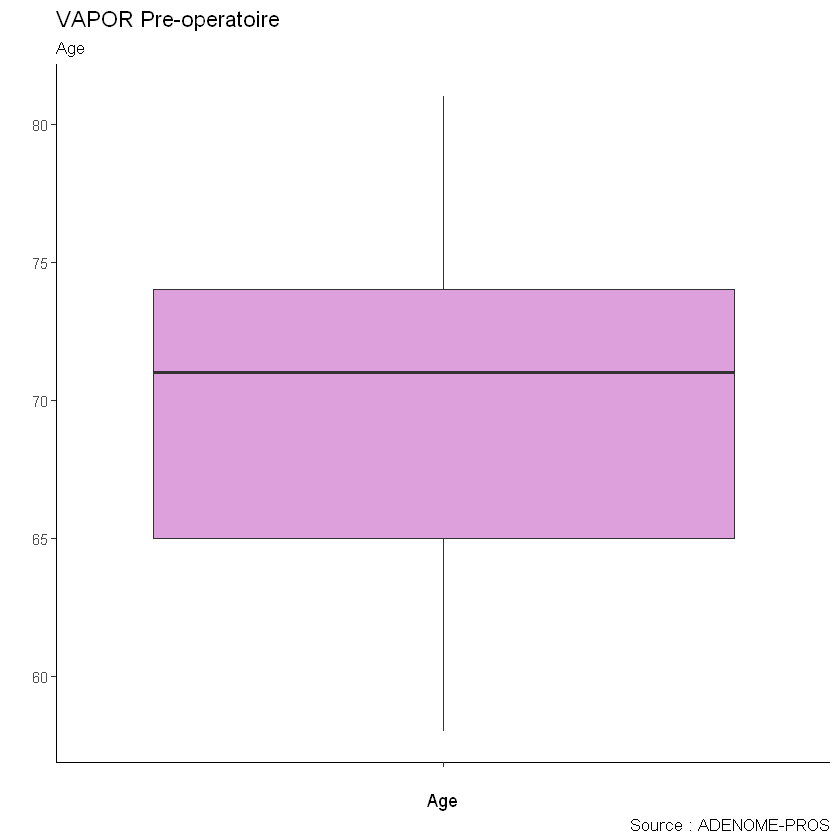

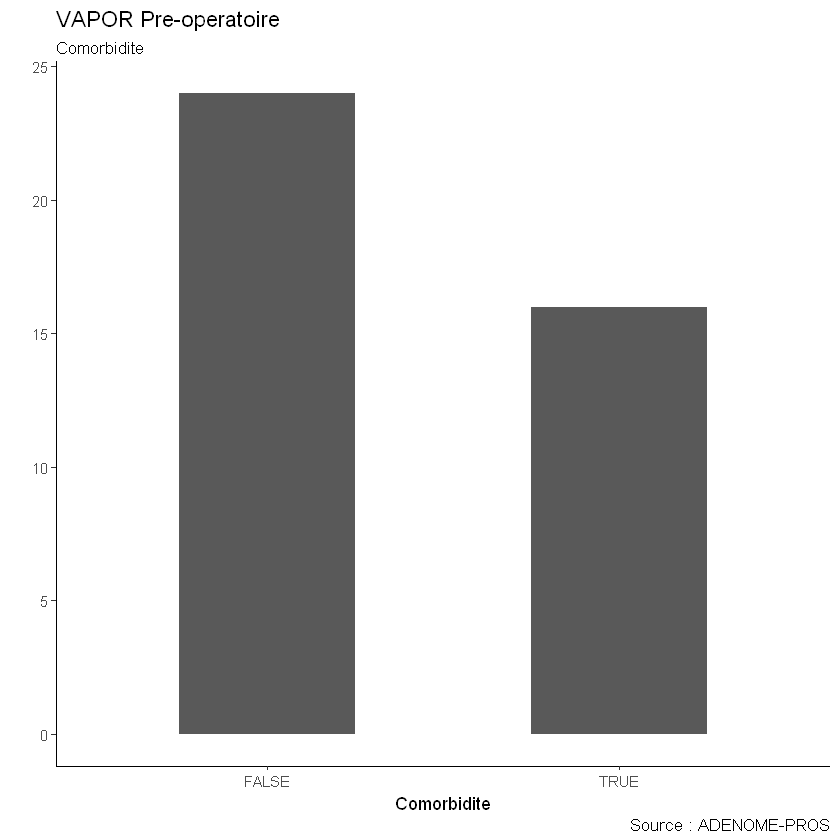

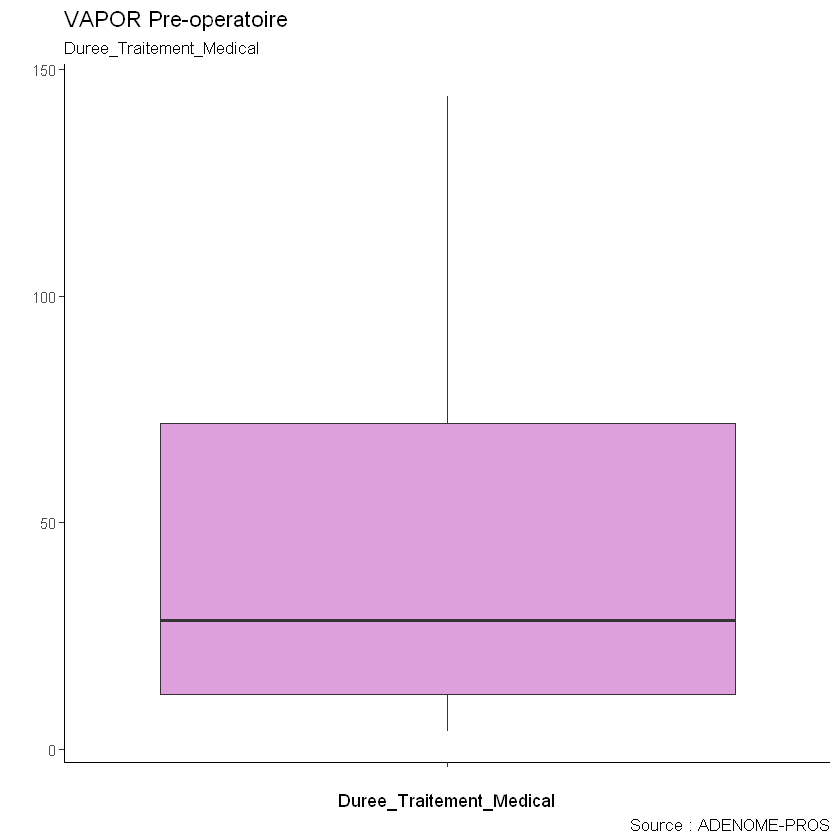

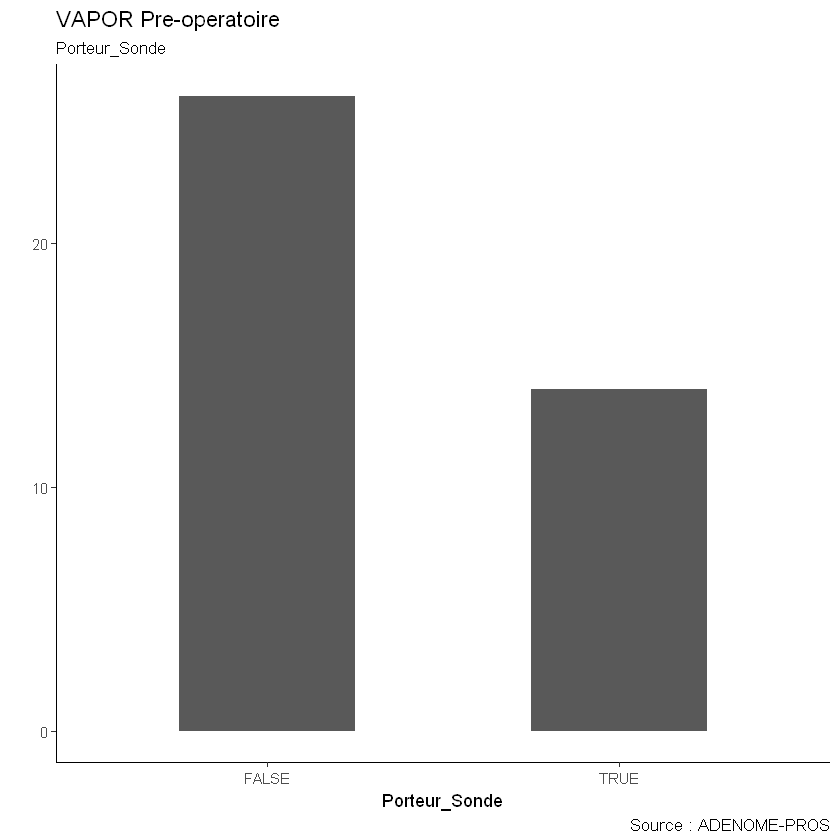

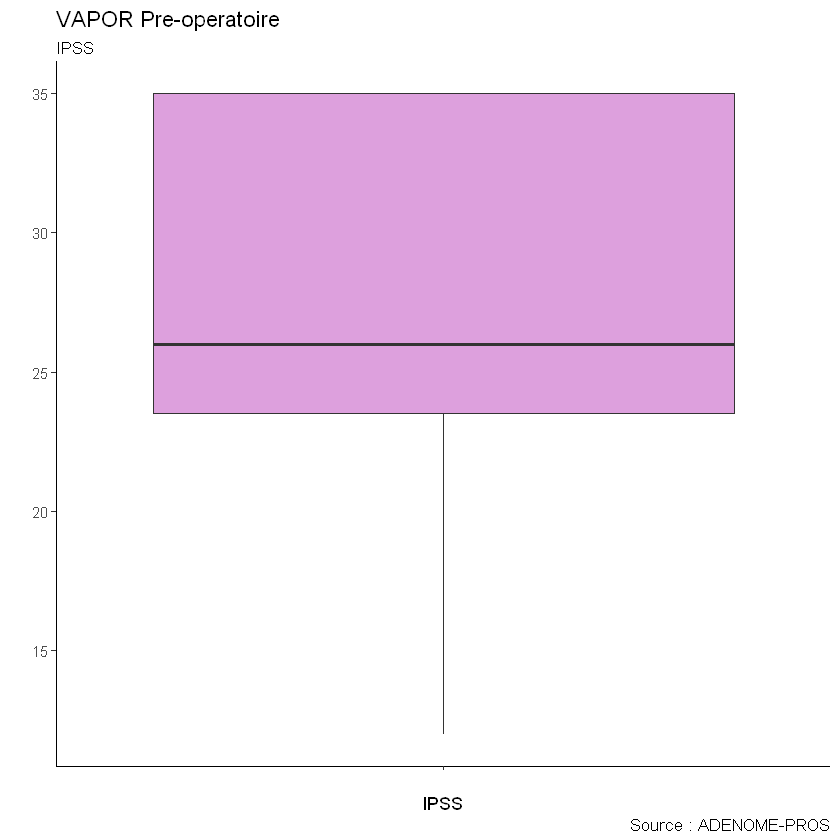

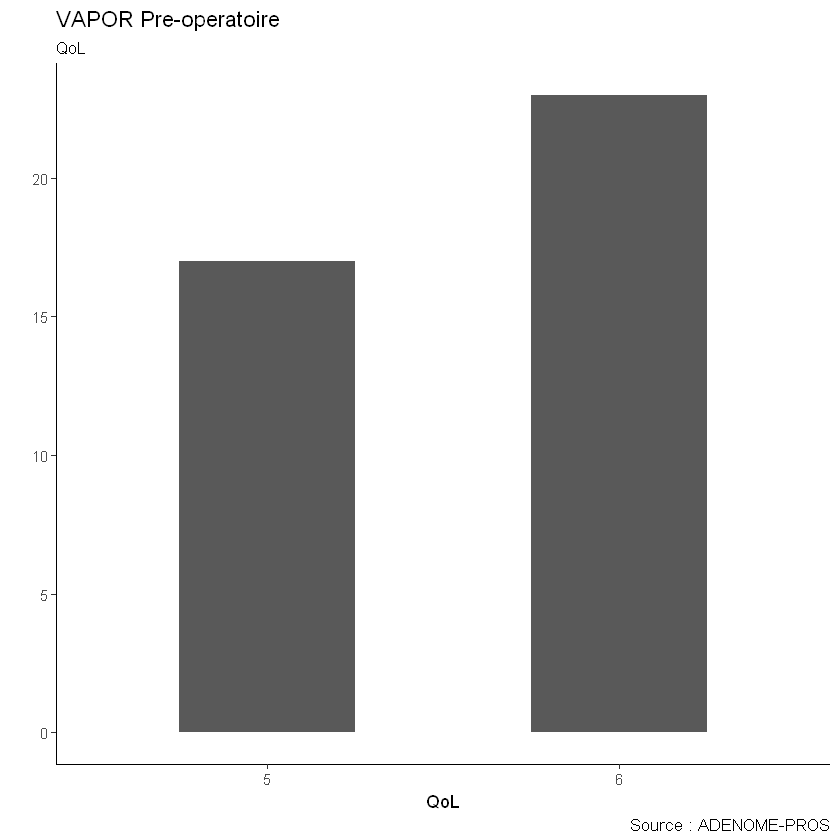

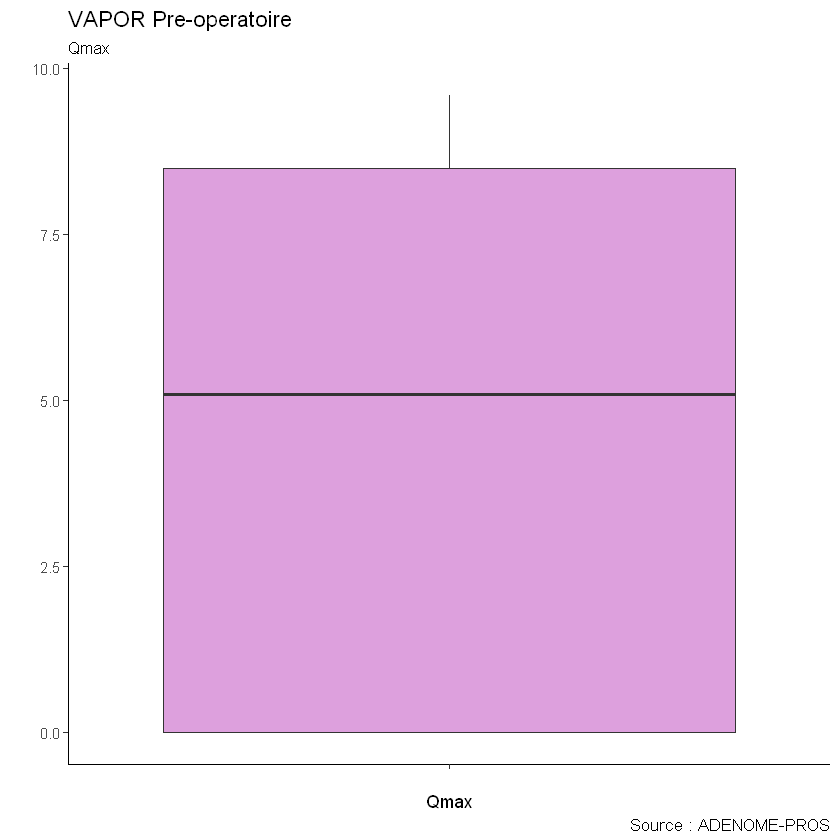

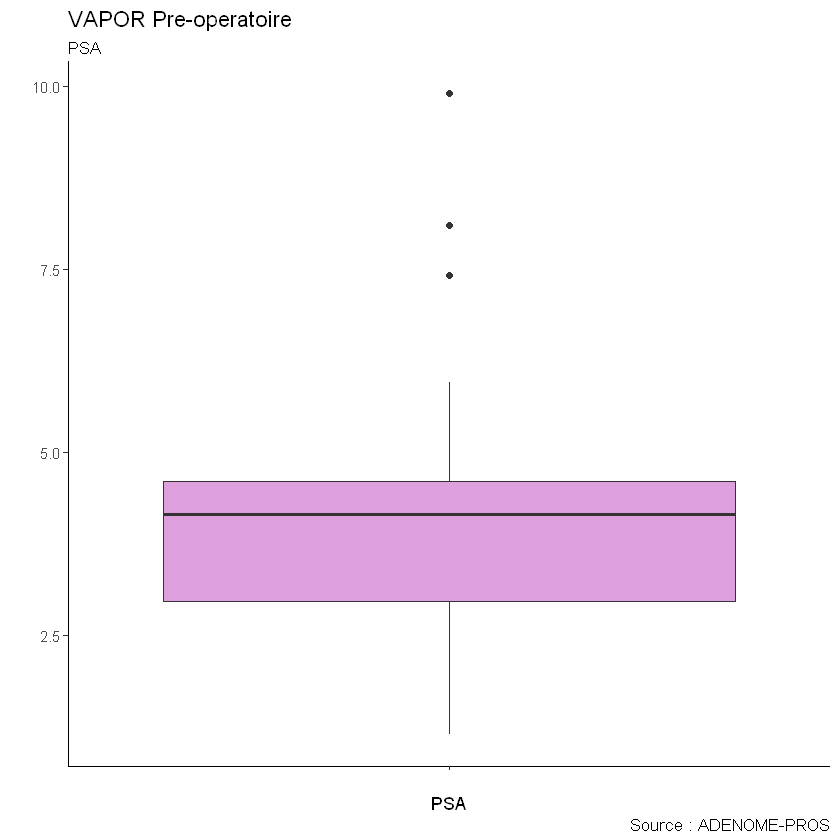

Warning message:
"Removed 14 rows containing non-finite values (stat_boxplot)."

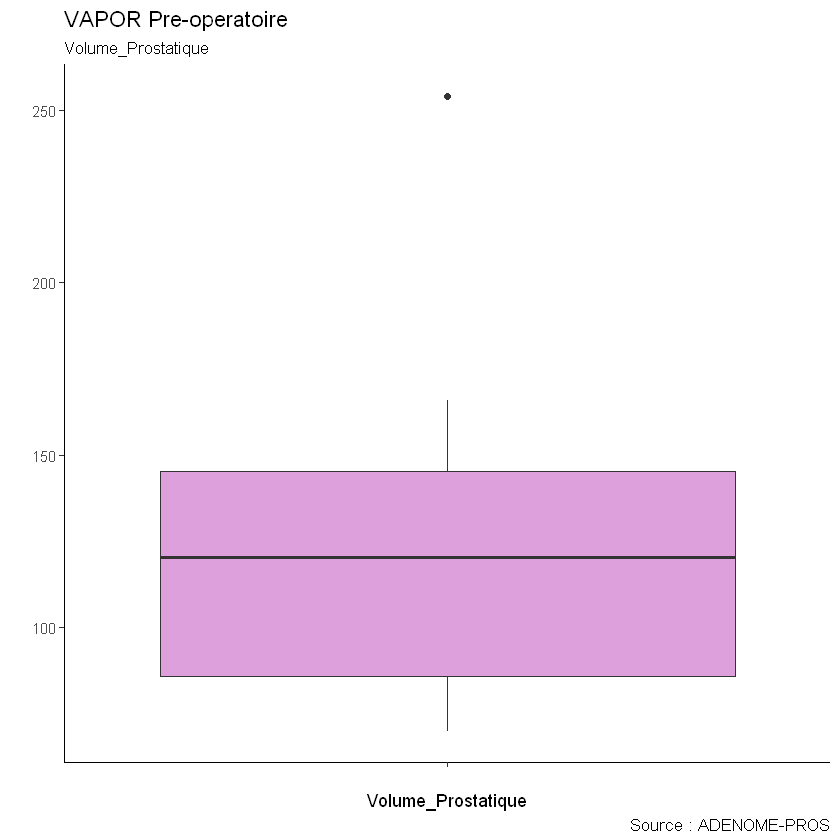

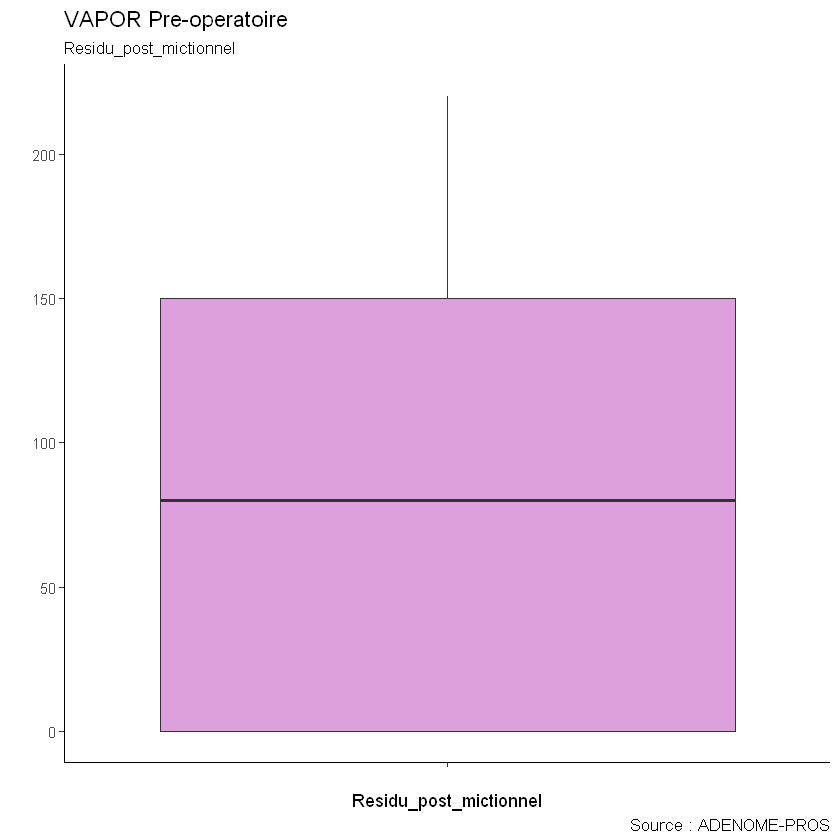

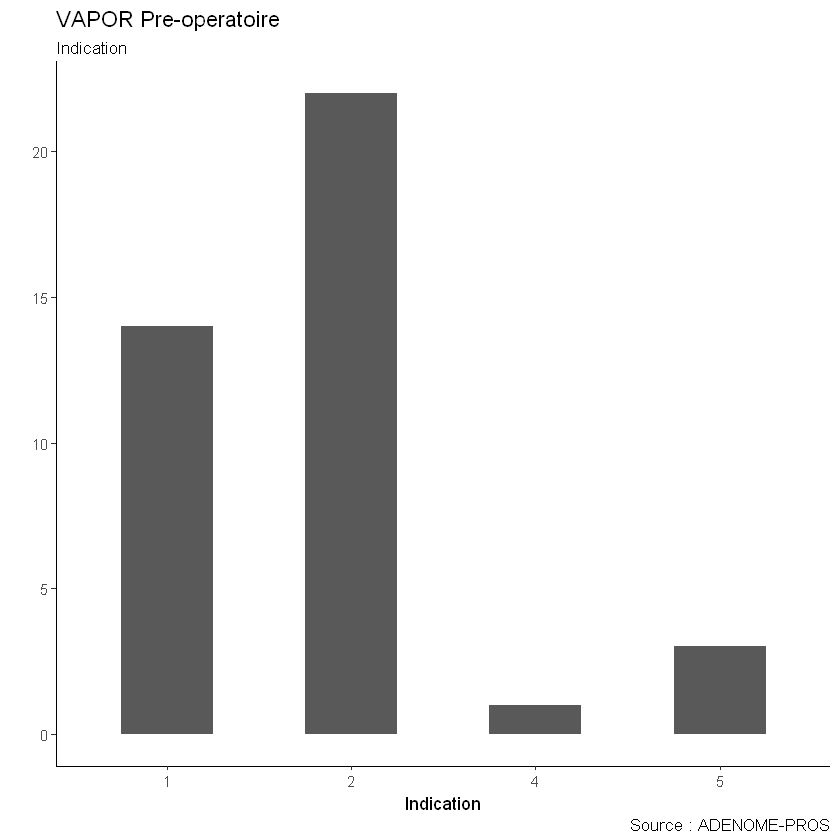

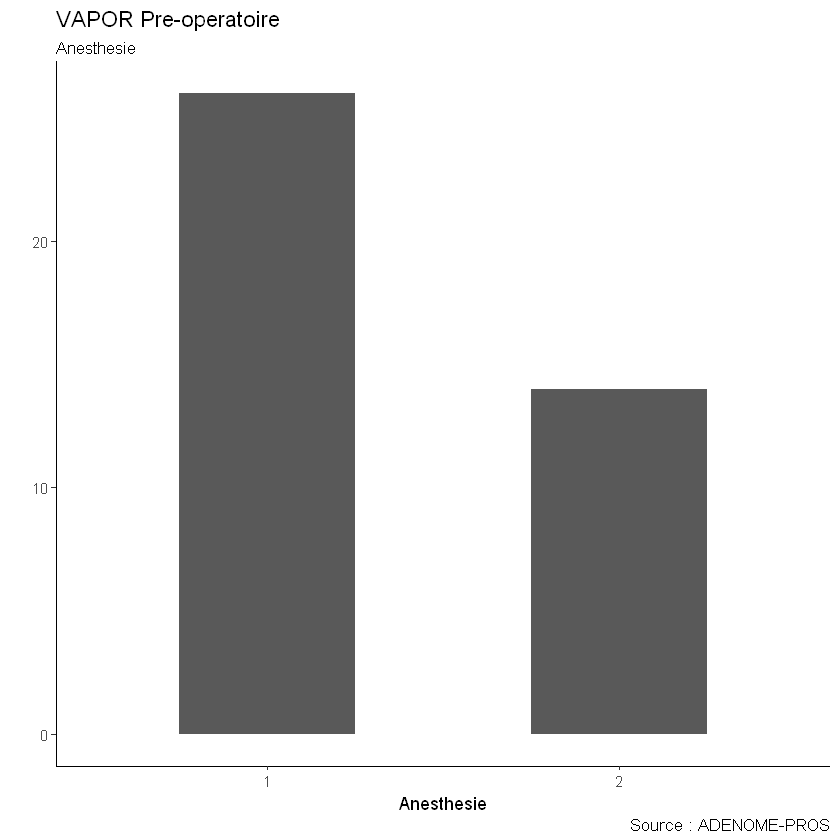

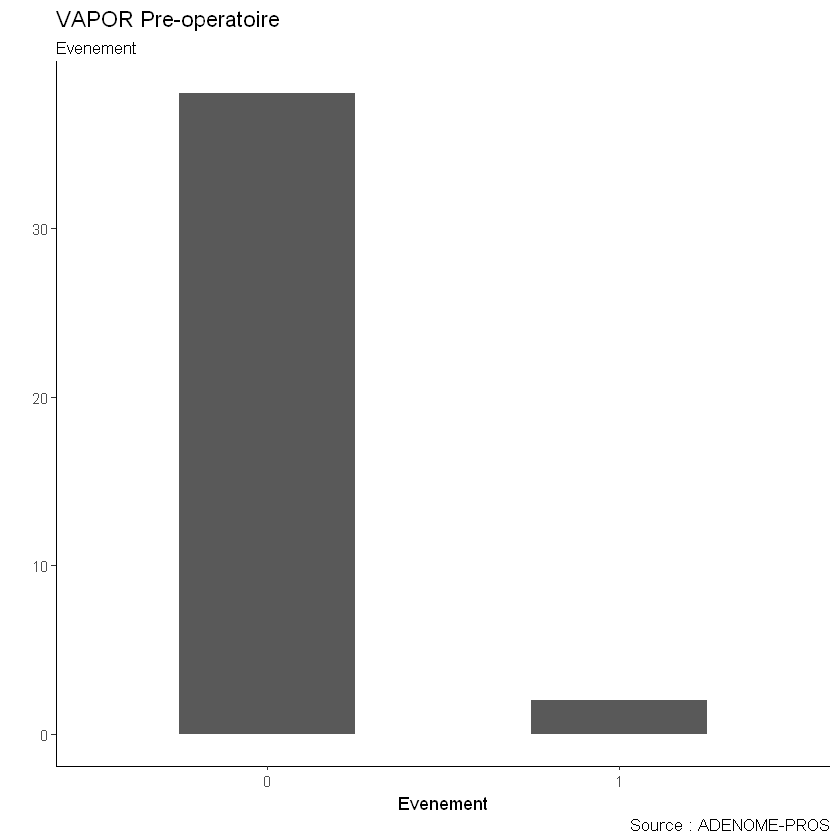

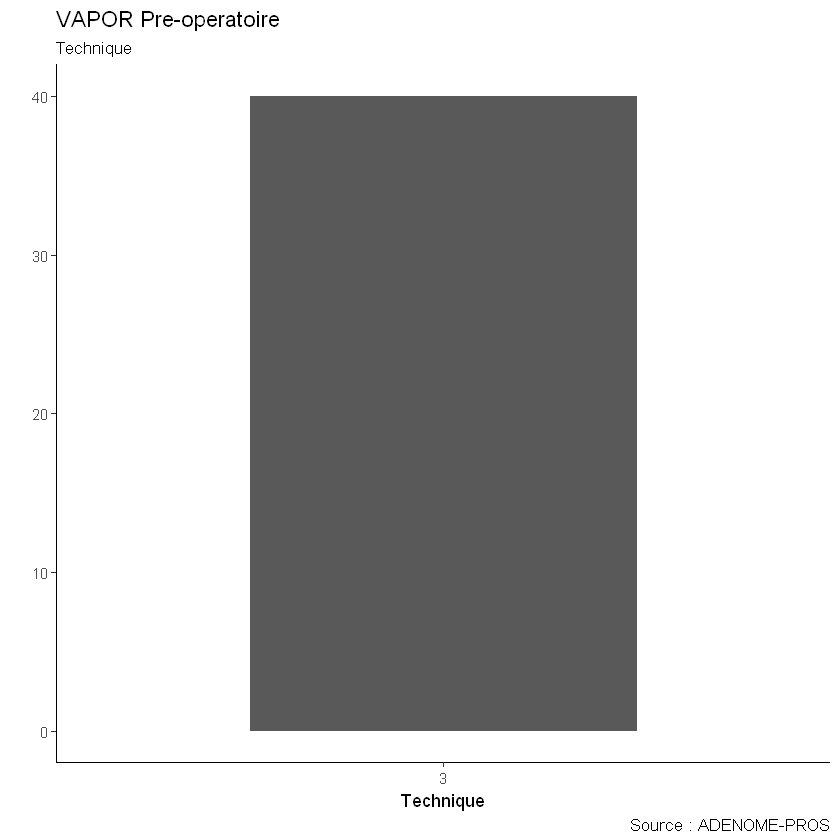

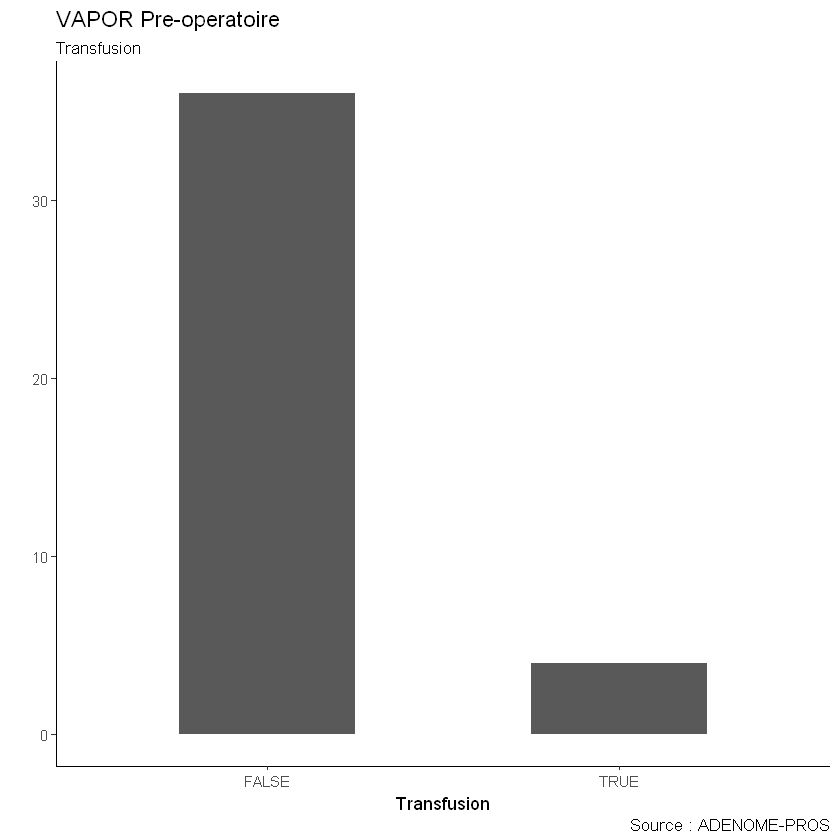

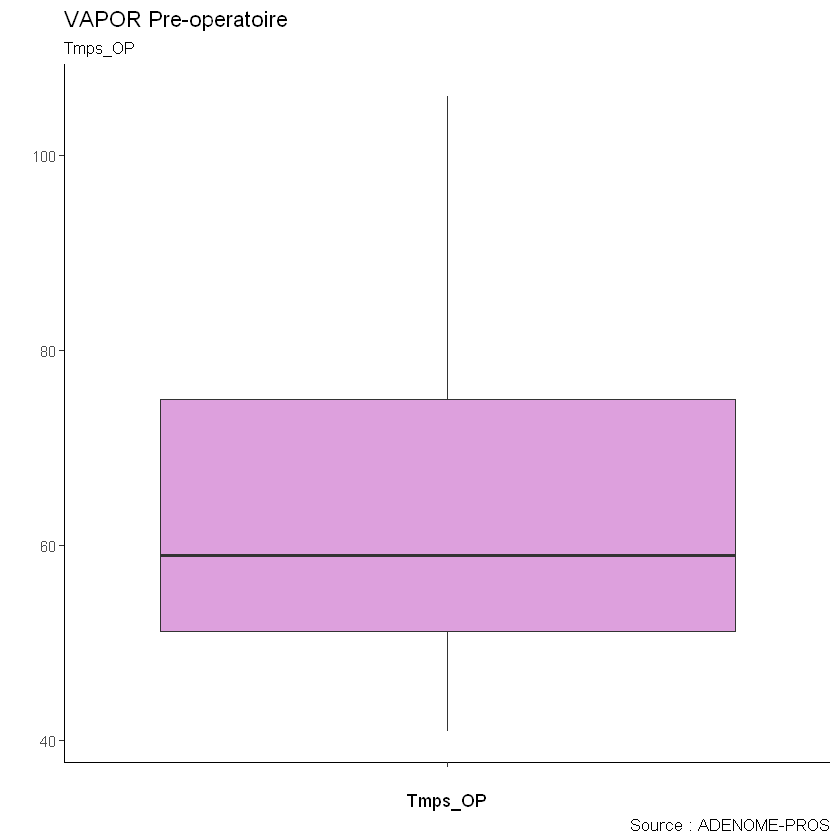

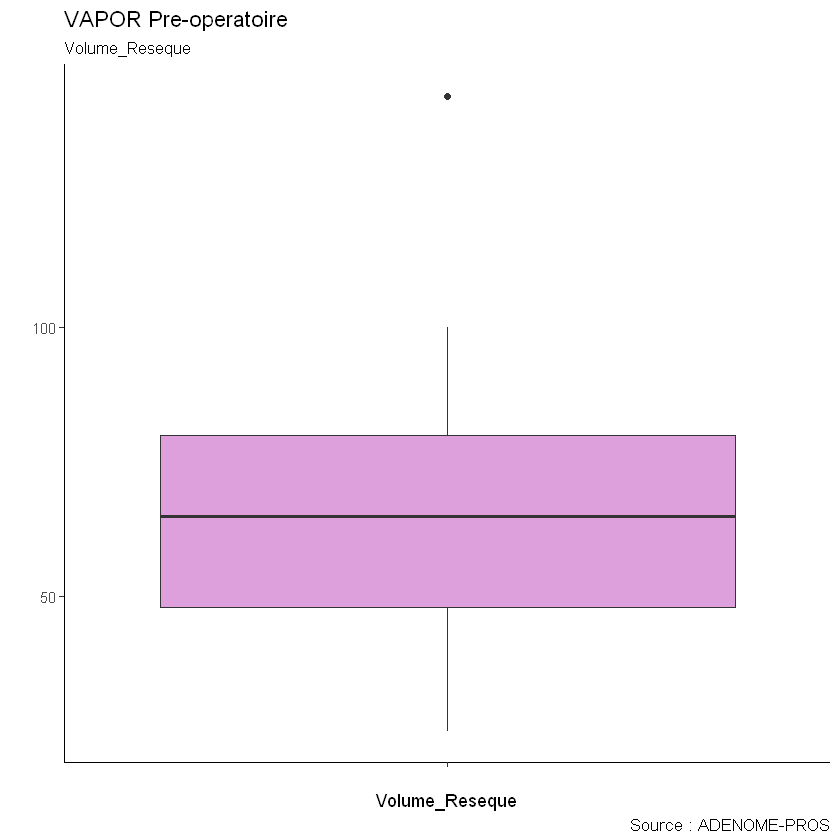

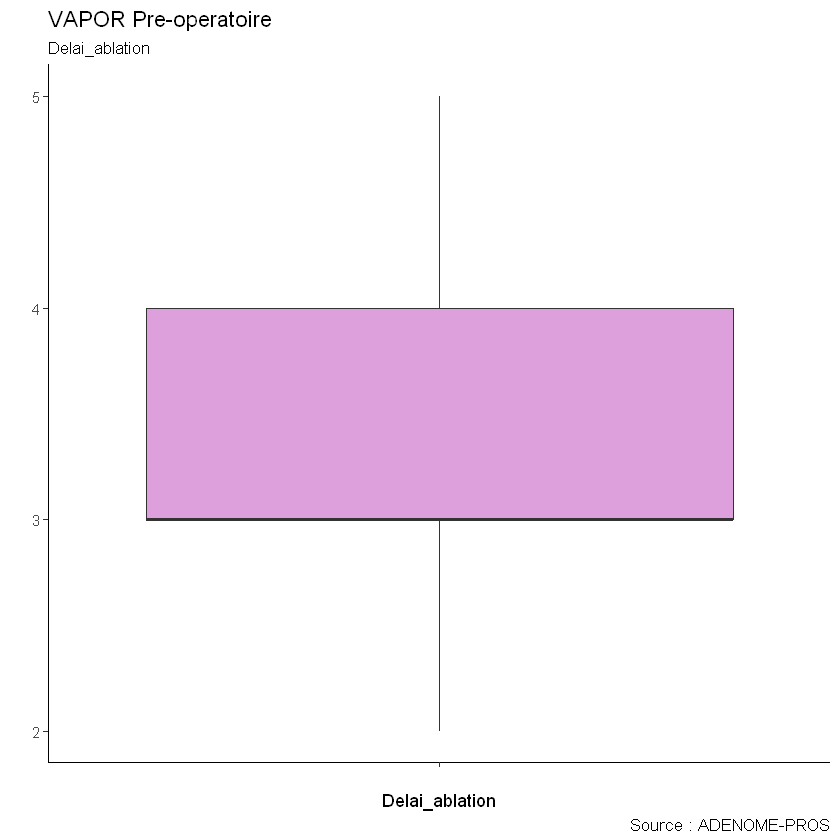

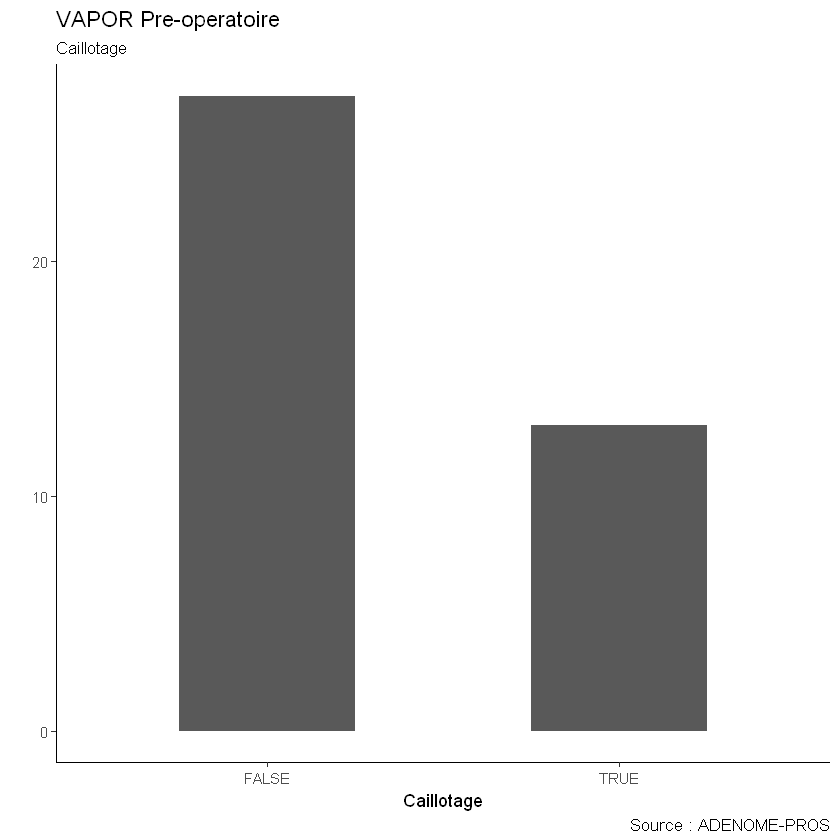

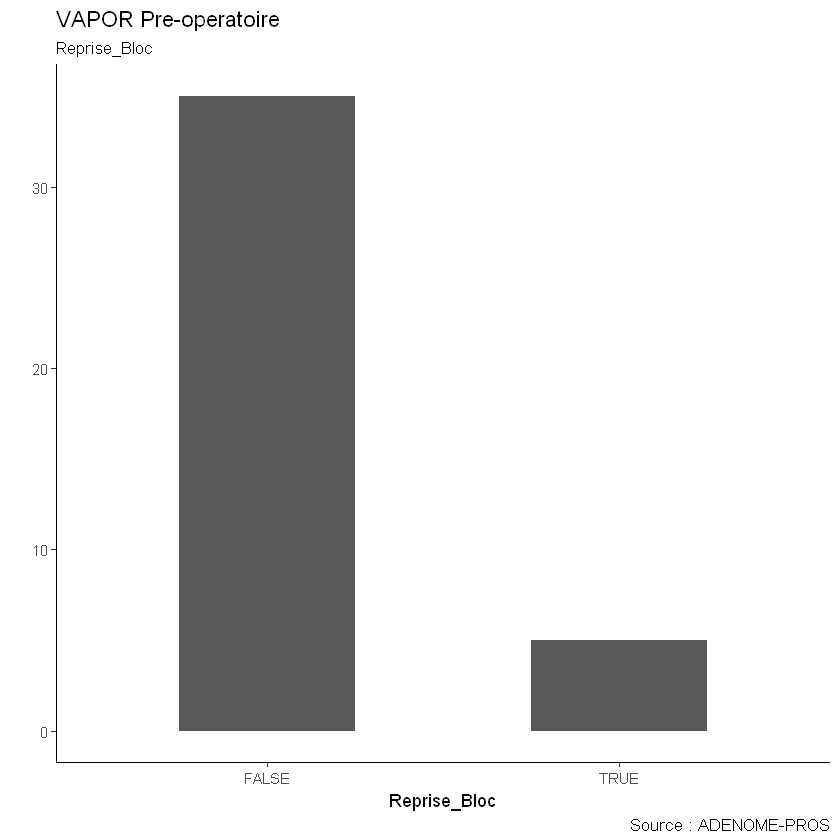

In [325]:
# Boxplots des variables numériques et barplots des variables catégoriques

for (i in 1:ncol(vapor_pre)) {
  #x11(display="")
  if (is.numeric(vapor_pre[,i]) || is.integer(vapor_pre[,i])) {
    adenome_boxplot(vapor_pre,i,"VAPOR Pre-operatoire")
  }
  else
    adenome_barplot(vapor_pre,i,"VAPOR Pre-operatoire")
}

Warning message:
"Removed 14 rows containing non-finite values (stat_boxplot)."

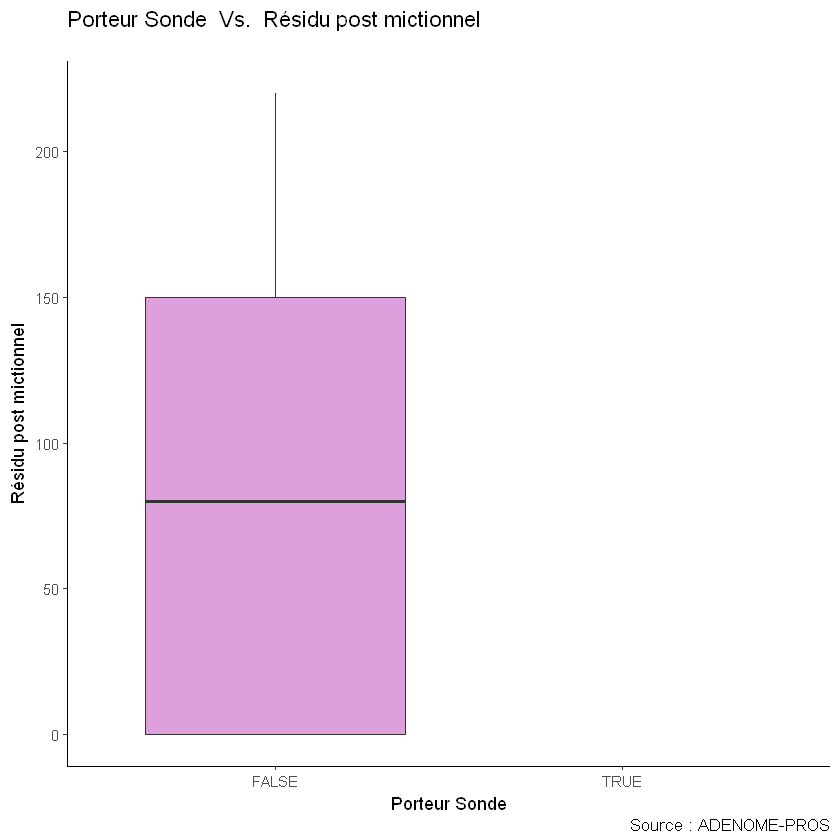

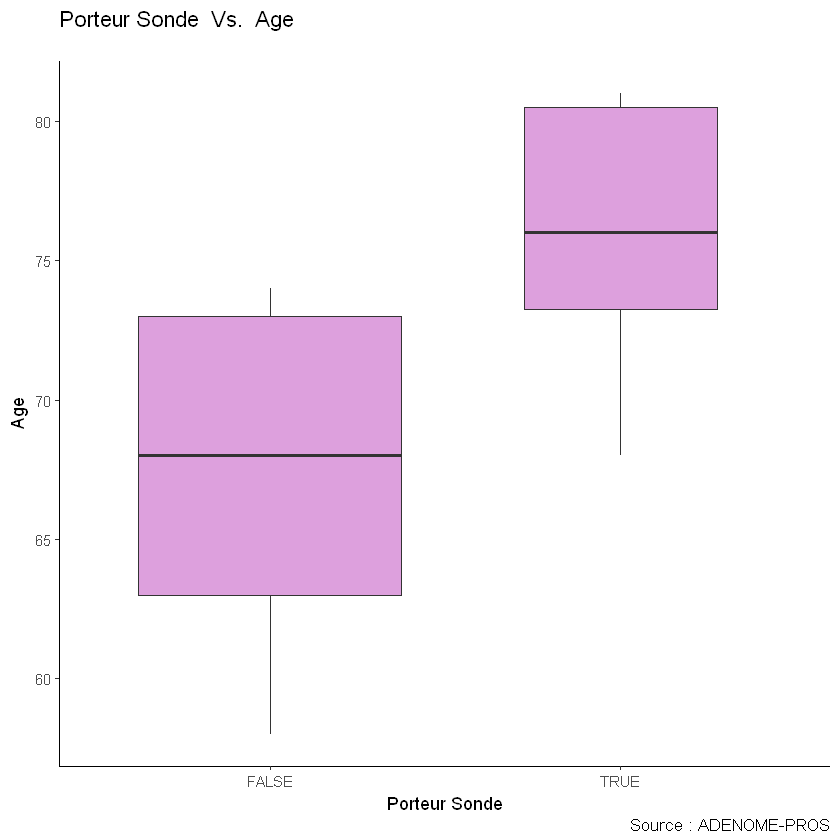

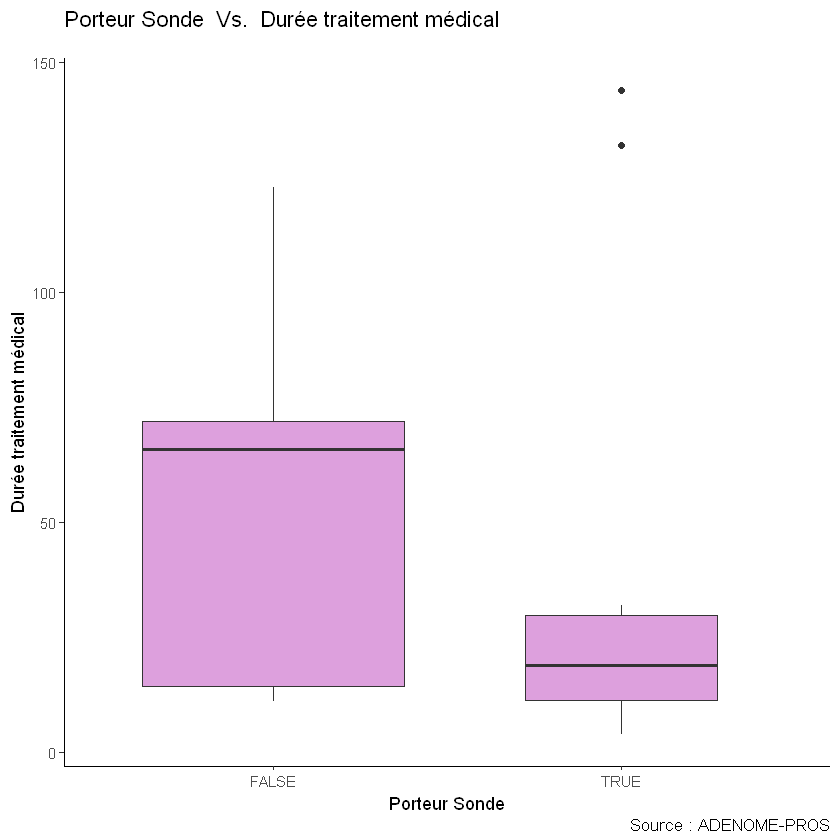

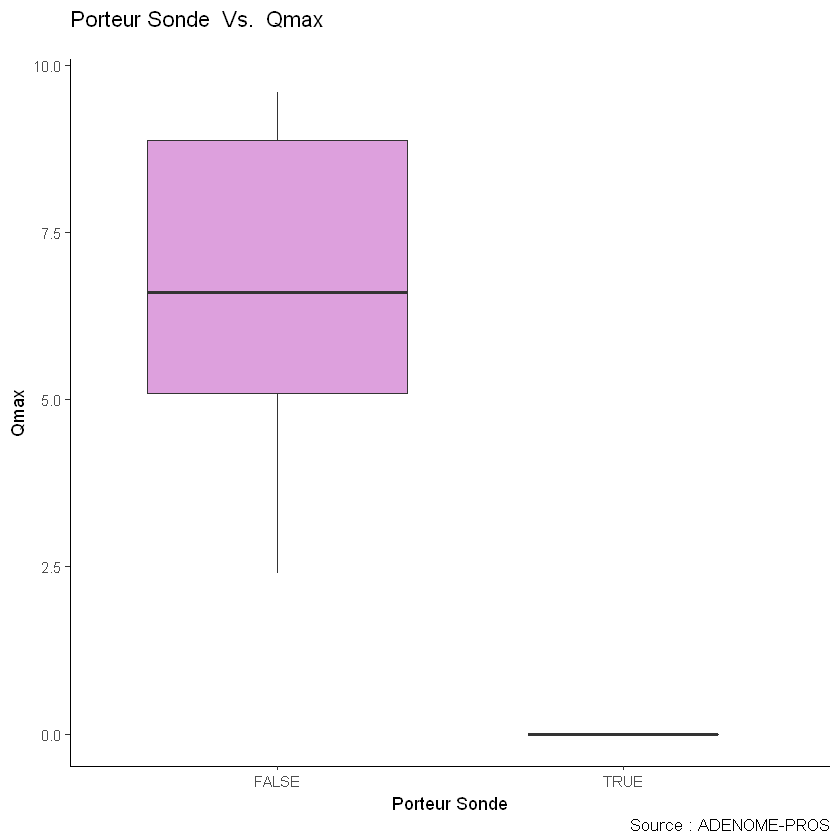

In [326]:
# Quelques distributions par rapport aux porteurs de sondes
adenome_boxplot_couple(vapor_pre, vapor_pre$Porteur_Sonde, vapor_pre$Residu_post_mictionnel, "Porteur Sonde", "Résidu post mictionnel")
adenome_boxplot_couple(vapor_pre, vapor_pre$Porteur_Sonde, vapor_pre$Age, "Porteur Sonde", "Age")
adenome_boxplot_couple(vapor_pre, vapor_pre$Porteur_Sonde, vapor_pre$Duree_Traitement_Medical, "Porteur Sonde", "Durée traitement médical")
adenome_boxplot_couple(vapor_pre, vapor_pre$Porteur_Sonde, vapor_pre$Qmax, "Porteur Sonde", "Qmax")

Logiquement, tous les porteurs de sonde ont un résidu mictionnel = 0. La qualité de leur miction n'est pas évaluée.
Les porteurs de sonde sont plus agés.
Les porteurs de sonde ont un traitement moins long.

### 1.1.2 Corrélations Heatmap

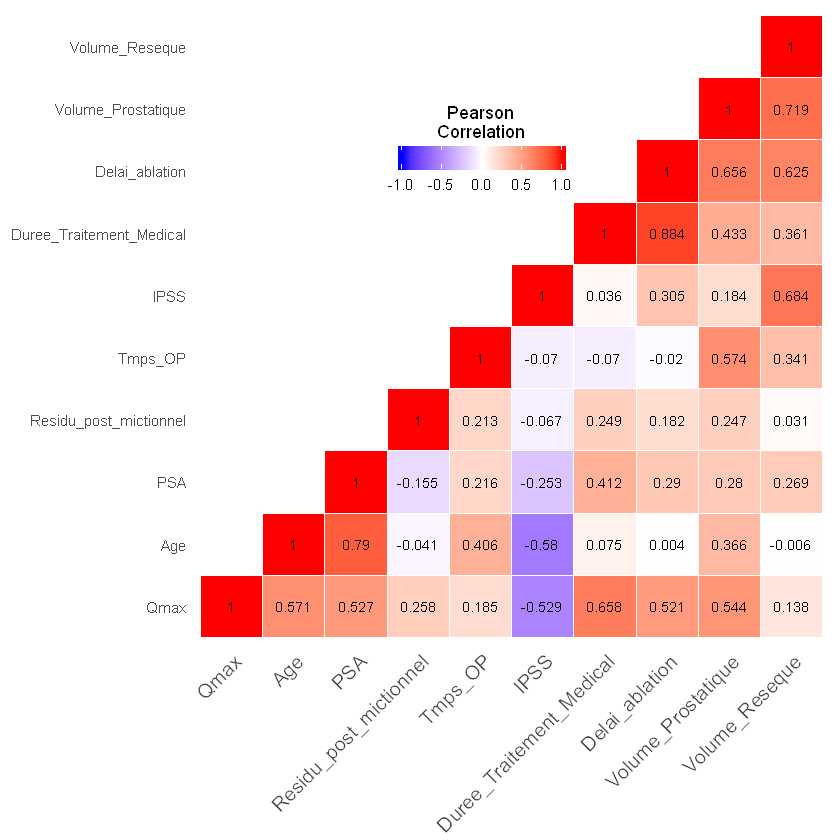

In [375]:
mat_cor_vapor_num_pre = cor(vapor_num_pre, method = c("pearson"))
adenome_heatmap(mat_cor_vapor_num_pre)

Pour la technique VAPOR, en pré-opératoire, nous notons une corrélation entre le "Volume Résequé" et le "Volume prostatique" ainsi qu'une corrélation négative entre "QMax"" et "IPSS". Plus la miction est bonne, plus la gêne est faible.
Dans une moindre mesure, nous notons une corrélation entre "Volume prostatique" et les variables suivantes :
- Temps OP
- Délai Ablation

Nous notons enfin une corrélation entre "Durée Traitement Médical" et "Délai Ablation".

Ces corrélations peuvent être confirmées par les Scatterplots ci-dessous.

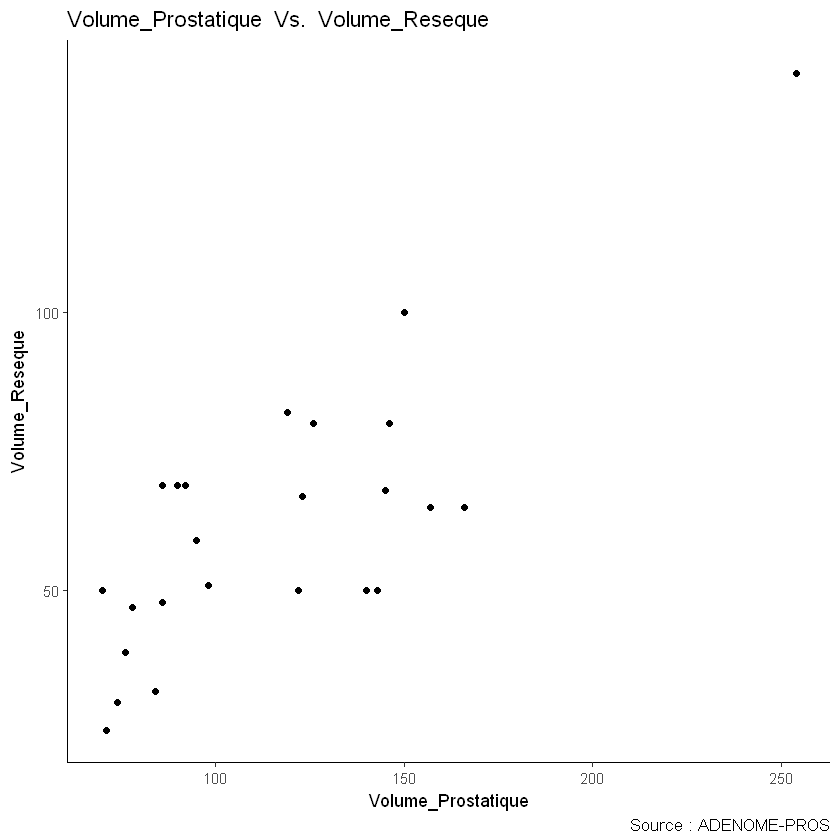

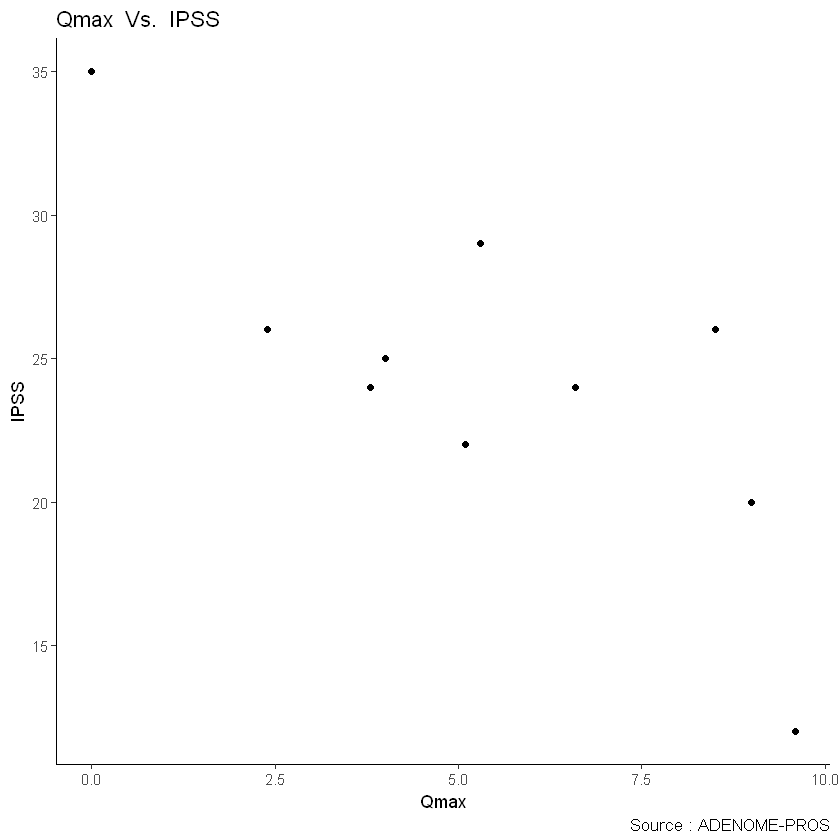

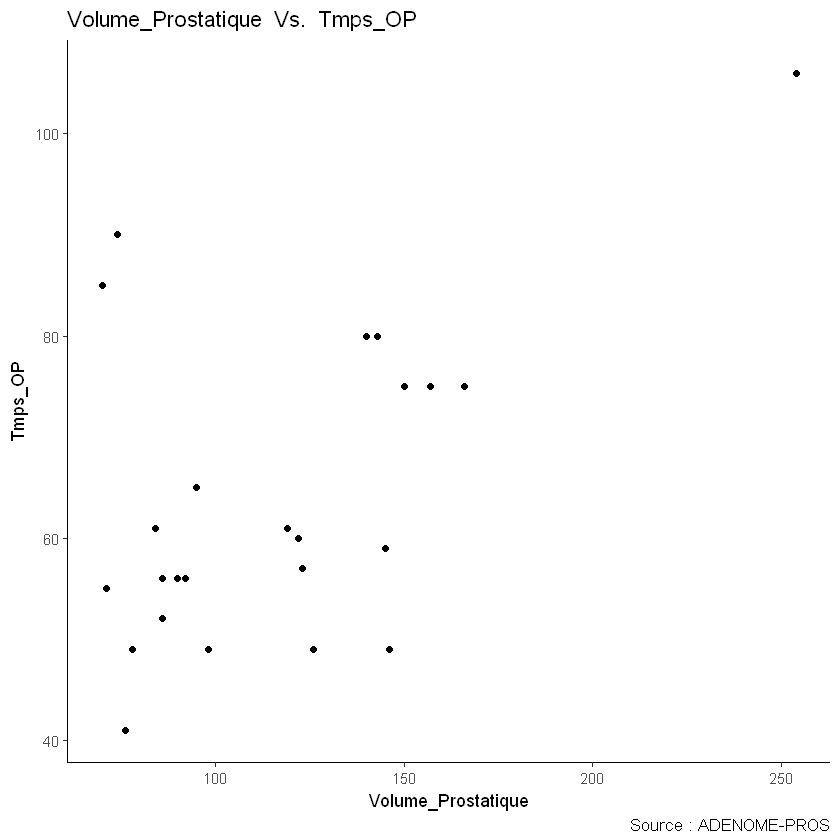

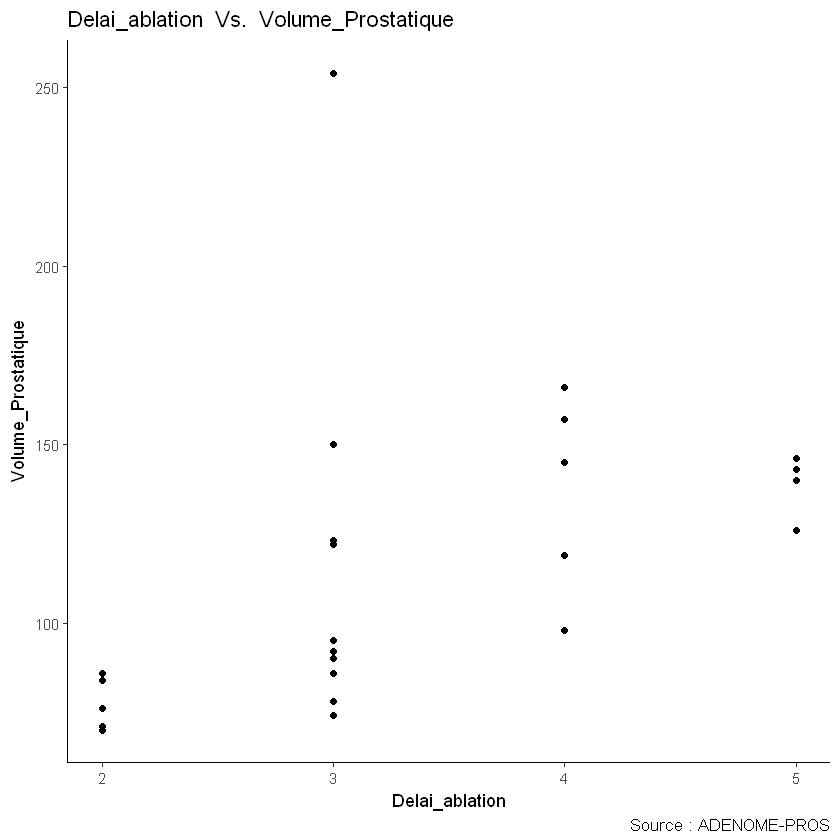

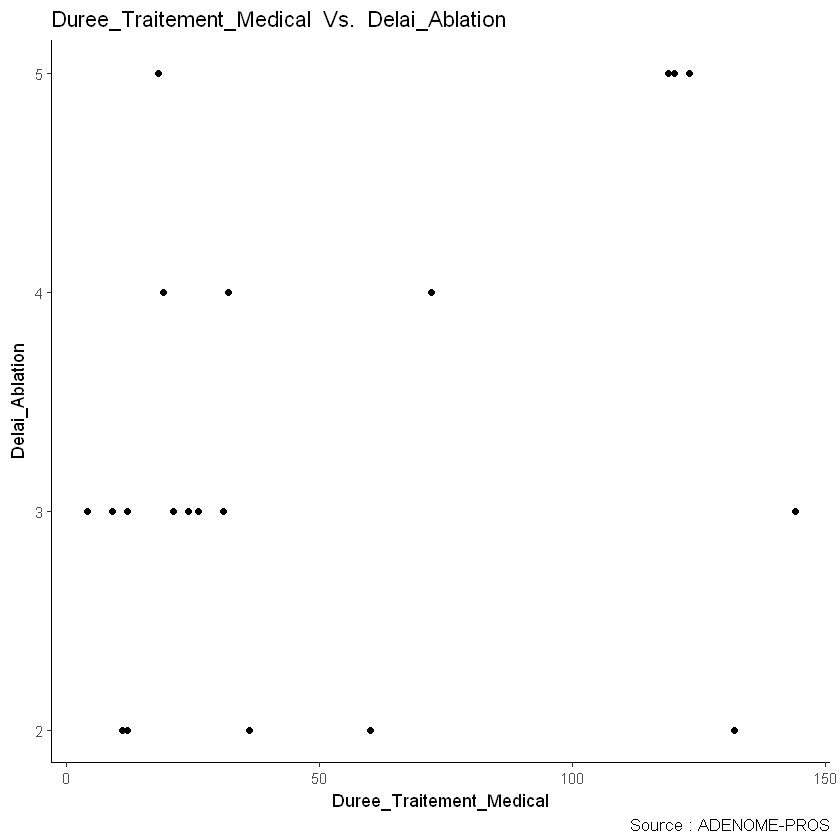

In [328]:
adenome_scatterplot(vapor_pre,vapor_pre$Volume_Prostatique,vapor_pre$Volume_Reseque,"Volume_Prostatique","Volume_Reseque")
adenome_scatterplot(vapor_pre,vapor_pre$Qmax,vapor_pre$IPSS,"Qmax","IPSS")
adenome_scatterplot(vapor_pre,vapor_pre$Volume_Prostatique,vapor_pre$Tmps_OP,"Volume_Prostatique","Tmps_OP")
adenome_scatterplot(vapor_pre,vapor_pre$Delai_ablation,vapor_pre$Volume_Prostatique,"Delai_ablation","Volume_Prostatique")
adenome_scatterplot(vapor_pre,vapor_pre$Duree_Traitement_Medical,vapor_pre$Delai_ablation,"Duree_Traitement_Medical","Delai_Ablation")

### 1.1.3 Corrélations de Kendall

Le coefficient de corrélation de Kendall est basé sur les rangs.

In [444]:
mat_cor_vapor_cat_pre = cor(vapor_cat_pre, method = c("kendall"))

ERROR: Error in cor(vapor_cat_pre, method = c("kendall")): 'x' must be numeric


### 1.1.4 Analyse en composantes principales

Pour faire une ACP il faut que tout les champs de toutes les variables soit renseignés. Cependant pour la variable'Residu post mictionnel' certains individus ont des valeurs non renseignée.Deux possibilités se présentent : 
-Supprimer tout les individus ayant la variable non renseignée 
ou 
-Suprimer la varible 'Residu post mictionnel'.
Pour celà il va falloir si la suppression de cette variable n'a aucun impact sur notre étude .

Ainsi on fait une matrice de corrélation sur les varibles numériques de vapor en enlevant les individus ayant un résidu post mictionnel non défini.

[1] 26

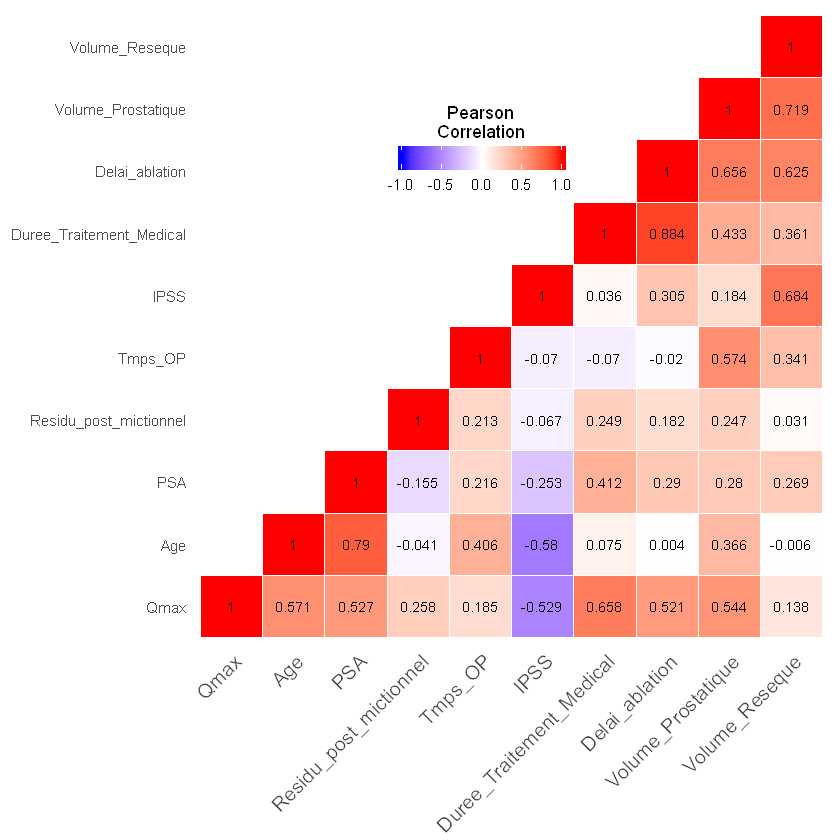

In [376]:
#Faut il garder le résidu post  ou l'enlever ? 
#On enlève tout les individus ayant un résidu post mictionnel=NA
vapor_num_pre_sans= subset(vapor_num_pre[which(vapor_num_pre$Residu_post_mictionnel != ""),])
nrow(vapor_num_pre_sans)
mat_cor_vapoor_num_pre = cor(vapor_num_pre_sans, method = c("pearson"))
adenome_heatmap(mat_cor_vapoor_num_pre )
   


Ainsi en créant une matrice de corrélation sans les individus ayant  le 'Residu post mictionnel' non définit on retrouve la matrice de corrélation ci-dessus. On peut déduire que la variable 'Residu post mictionnel' n'est corrélée à aucune autre variable et donc on peut déduire qu'elle peut être une composante intéréssante à garder pour notre étude. On peut également faire une ACP pour confirmer l'intêret de garder cette variable dans notre jeu de données. 

Ainsi on fait une analyse en composantes principales sur les varibles numériques de vapor en enlevant les individus ayant un résidu post mictionnel non défini.

In [373]:

pca <- stats::prcomp(x=subset(vapor_num_pre_sans))
pca[]
summary(pca)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
Age,0.0004453695,-0.02814998,0.040427863,-0.22188161,0.085894403,0.83118962,0.390789386,-0.020368281,-0.290550868,0.1119663457
Duree_Traitement_Medical,-0.1738273414,-0.69571824,-0.680800063,-0.05596573,0.126486571,-0.03760712,0.028395490,-0.008716080,-0.023051856,-0.0176774409
IPSS,0.0023480168,-0.02318152,0.032575620,0.25394657,-0.041341130,-0.31899226,0.730692149,0.483429850,-0.070321448,0.2405854903
Qmax,-0.0098944784,-0.03081499,-0.011874643,-0.08353452,-0.013610112,0.17696431,-0.513219879,0.733017765,-0.020572274,0.3989974978
PSA,0.0017865406,-0.01767210,-0.004844929,-0.01895752,0.059213760,0.26447219,0.158075146,0.195548125,0.899783818,-0.2302435581
Volume_Prostatique,-0.1480696991,-0.58726276,0.610579270,-0.35830493,-0.343350007,-0.10856362,0.026330580,-0.002335165,0.027242566,-0.0298688629
Residu_post_mictionnel,-0.9723380552,0.22679754,0.009450218,0.04962941,-0.009999903,0.02142559,0.002479393,-0.001180834,0.001578932,-0.0003287295
Tmps_OP,-0.0370559596,-0.05711579,0.266986419,-0.25107305,0.907256182,-0.18896713,0.013510081,0.024102433,-0.007067998,0.0375427186
Volume_Reseque,-0.0303729499,-0.33667792,0.299036015,0.82572676,0.172100089,0.23728032,-0.150968379,-0.064432966,-0.033692523,-0.0219000320
Delai_ablation,-0.0039574939,-0.02134369,-0.007111440,0.01011284,-0.022388812,-0.02087832,0.022594666,-0.430710168,0.313272673,0.8451492436


Importance of components%s:
                           PC1     PC2     PC3      PC4     PC5     PC6     PC7
Standard deviation     82.3762 45.3519 30.8705 14.13017 8.72110 4.53780 1.79281
Proportion of Variance  0.6722  0.2037  0.0944  0.01978 0.00753 0.00204 0.00032
Cumulative Proportion   0.6722  0.8759  0.9703  0.99008 0.99761 0.99965 0.99997
                           PC8     PC9   PC10
Standard deviation     0.45901 0.23404 0.1108
Proportion of Variance 0.00002 0.00001 0.0000
Cumulative Proportion  0.99999 1.00000 1.0000

Ainsi en faisant l'ACP on voit clairement que le 'Résidu post mictionnel' a une grande influence sur la PC1 . Ceci nous confirme le fait de devoir garder cette varaible pour la suite de notre étude et de supprimer les individus qui n'en possèdent pas. 

In [367]:
sum(100 * (pca$sdev^2)[1:3] / sum(pca$sdev^2))

[1] 97.03031

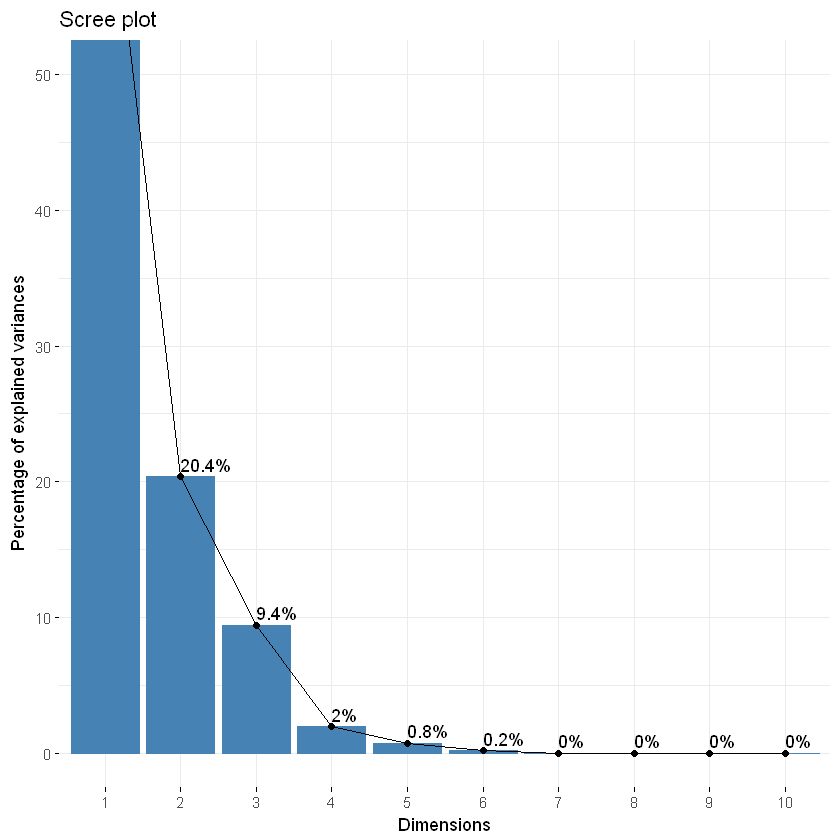

In [368]:
library(factoextra)
fviz_eig(pca, addlabels = TRUE, ylim = c(0, 50))

Ainsi  d'après le graphe ci-dessus et d'aprés la valeur de la proportion cumulative on peut déduire que les troiss premières composantes sont les plus représentatives. En effet ces composantes à elles seules contiennent 97.03% de l'information, il est donc raisonnable de garder seulement ces trois varibles.

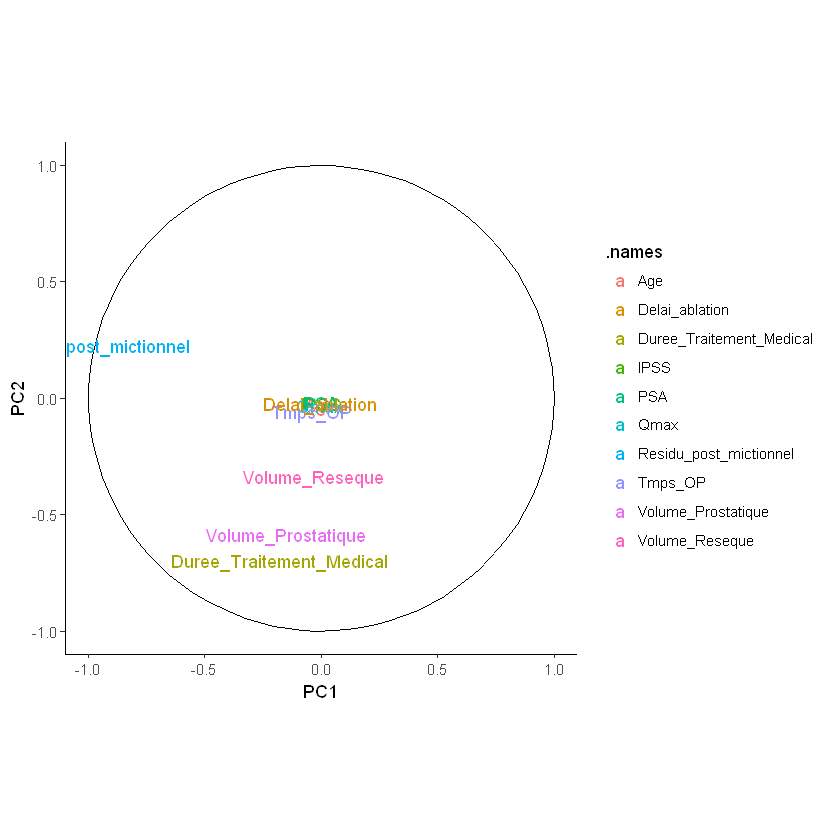

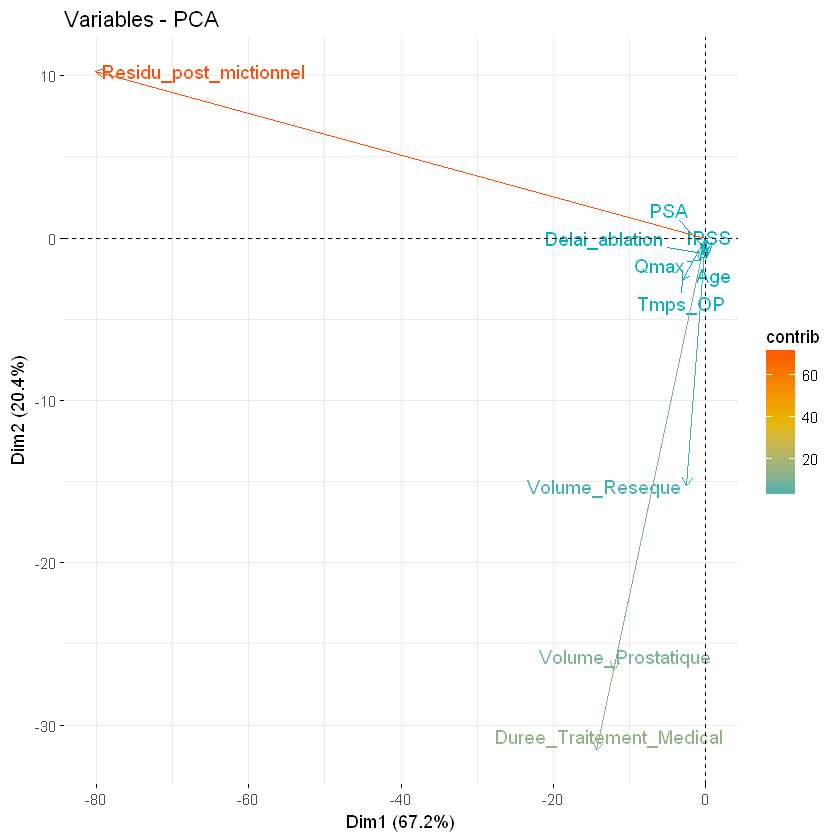

In [369]:
theta <- seq(0,2*pi,length.out = 100)
circle <- data.frame(x = cos(theta), y = sin(theta))
p <- ggplot(circle,aes(x,y)) + geom_path()
loadings <- data.frame(pca$rotation, 
.names = row.names(pca$rotation))
p + geom_text(data=loadings, 
mapping=aes(x = PC1, y = PC2, label = .names, colour = .names)) +
  coord_fixed(ratio=1) +
  labs(x = "PC1", y = "PC2")

fviz_pca_var(pca, col.var = "contrib",
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
             repel = TRUE # Évite le chevauchement de texte
             )

En observant le graphe ci-dessus on peut déduire que les variables qui contribue le plus dans la PC1 et la PC2  sont les variables: residu post mictionnel, durée de traitement médical, volume prostatique ,volume reseque.

# 1.2 Post-opératoire

### 1.2.1 Distributions

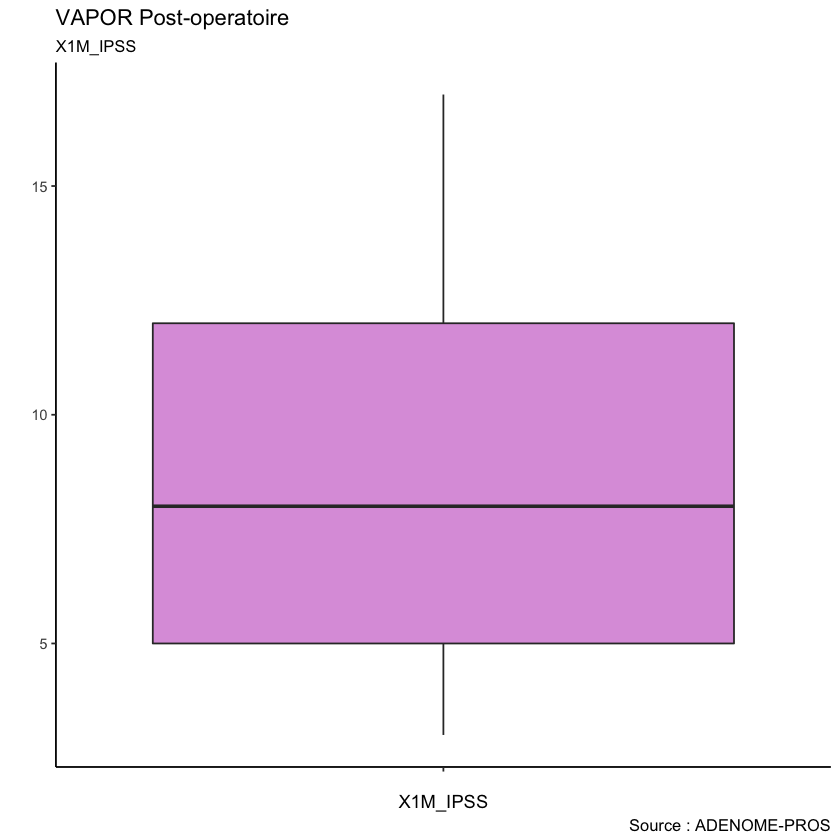

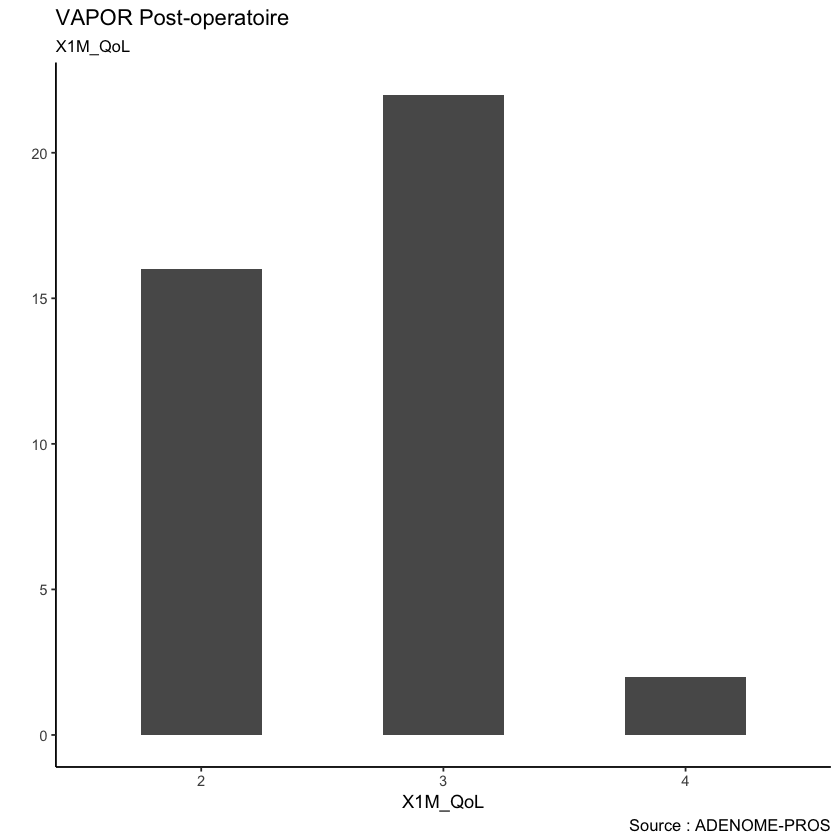

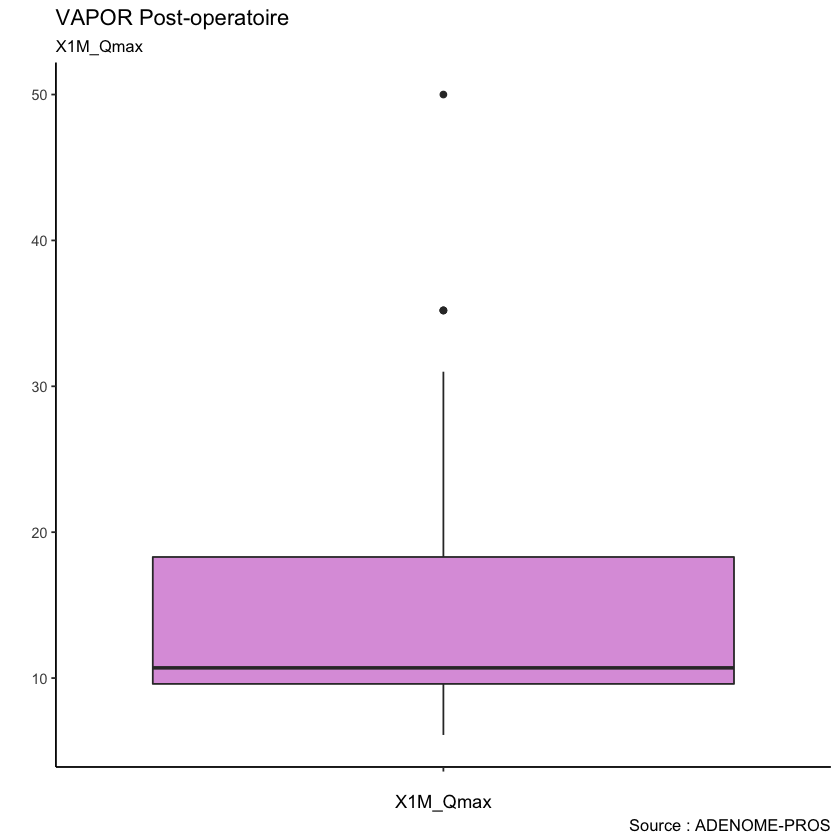

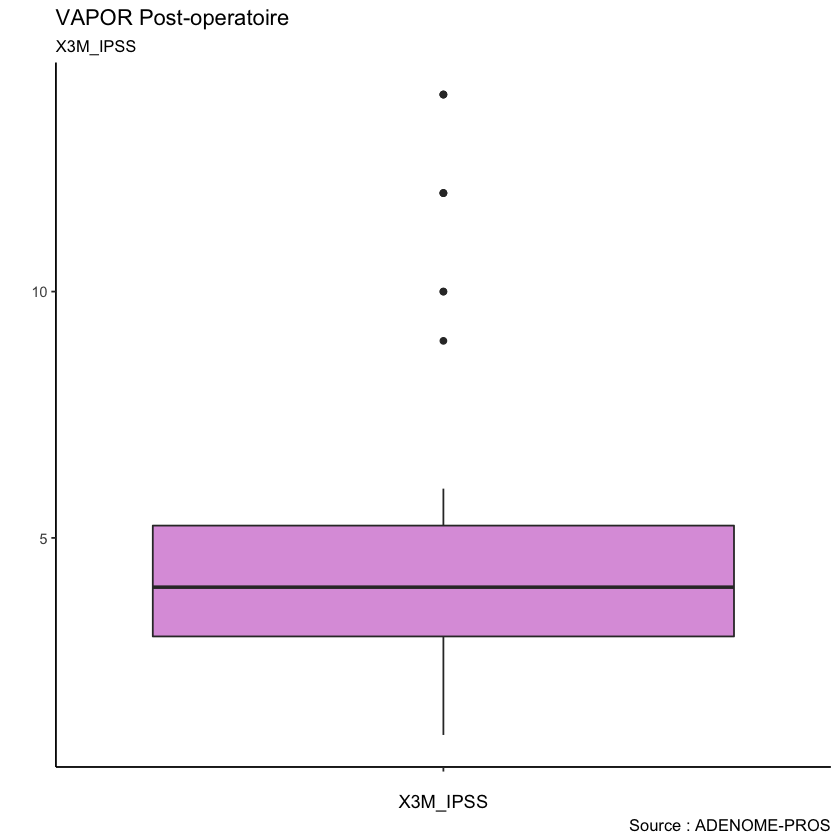

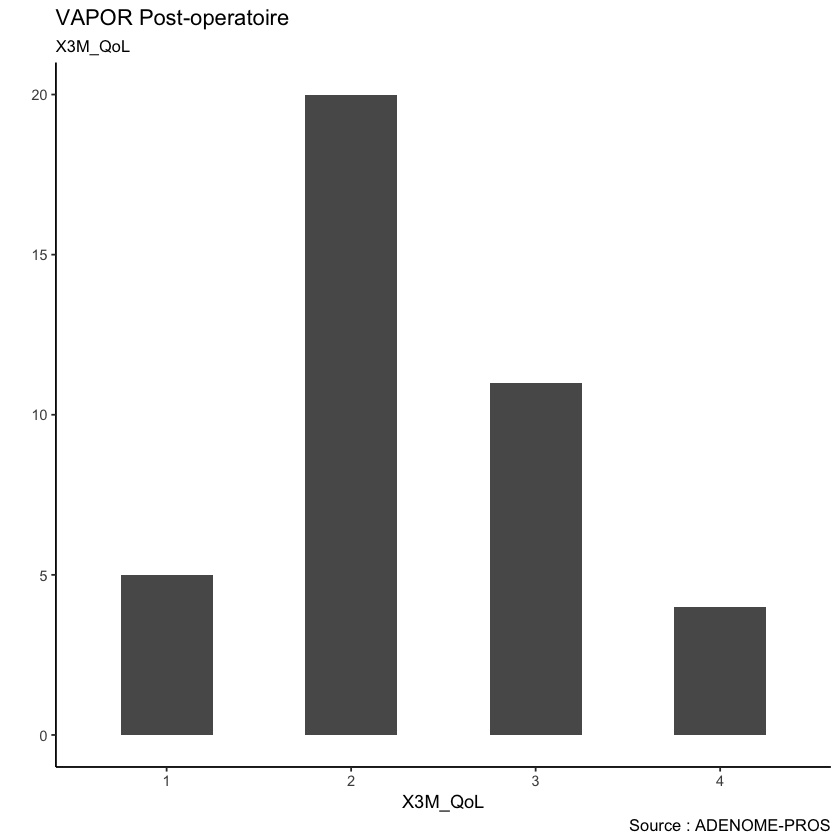

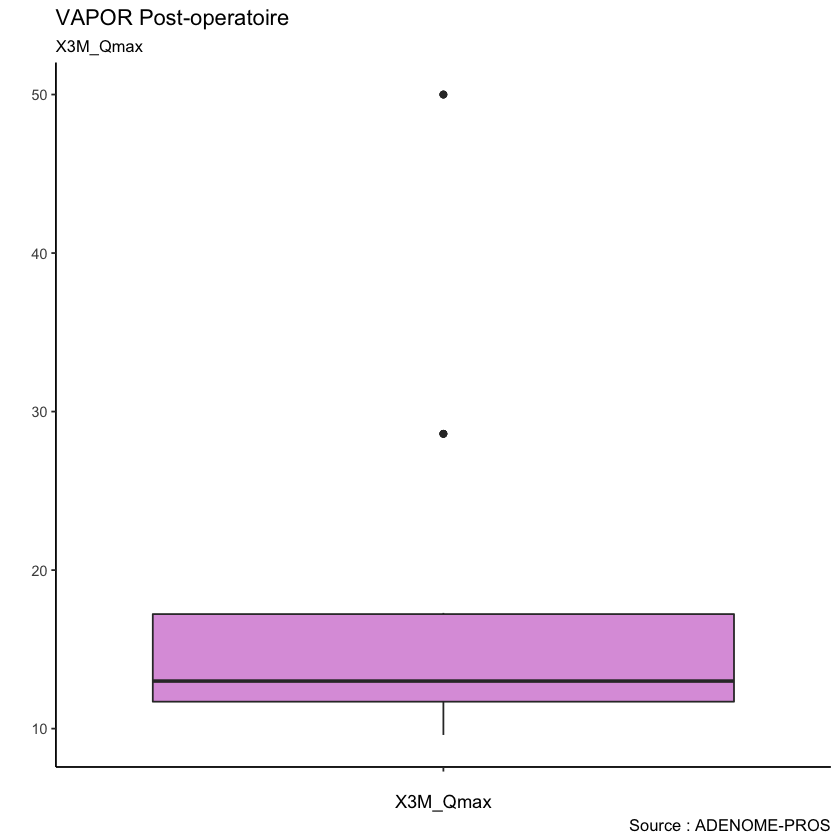

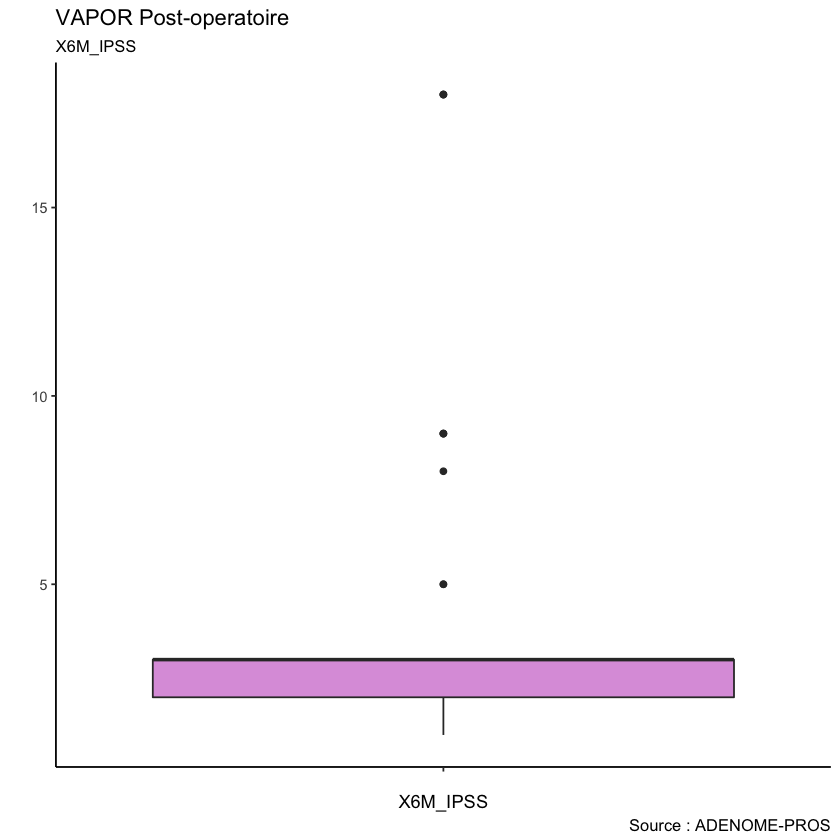

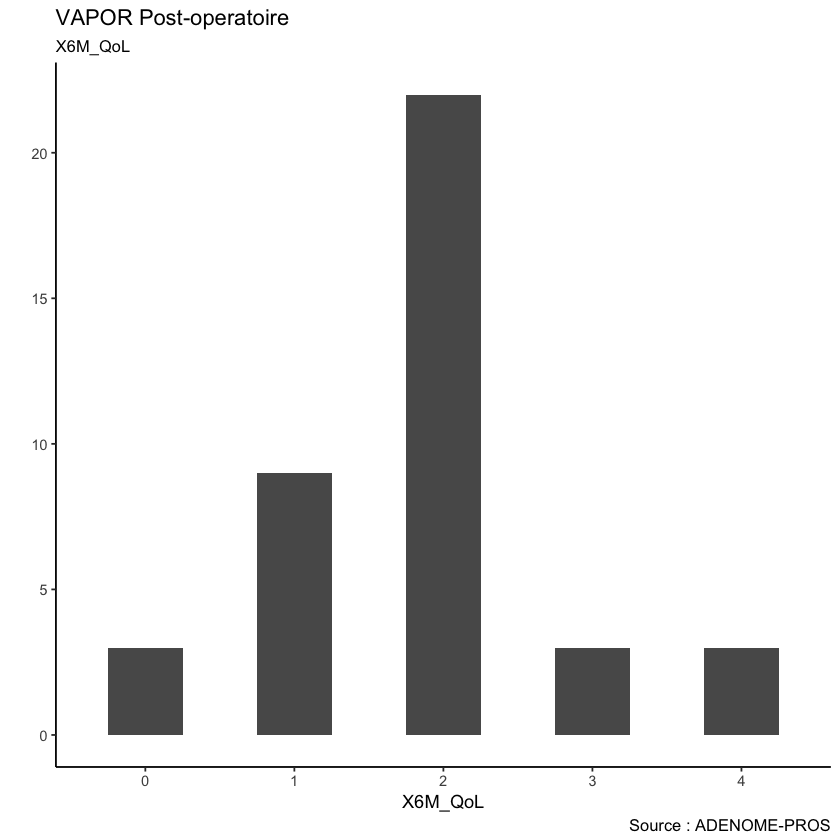

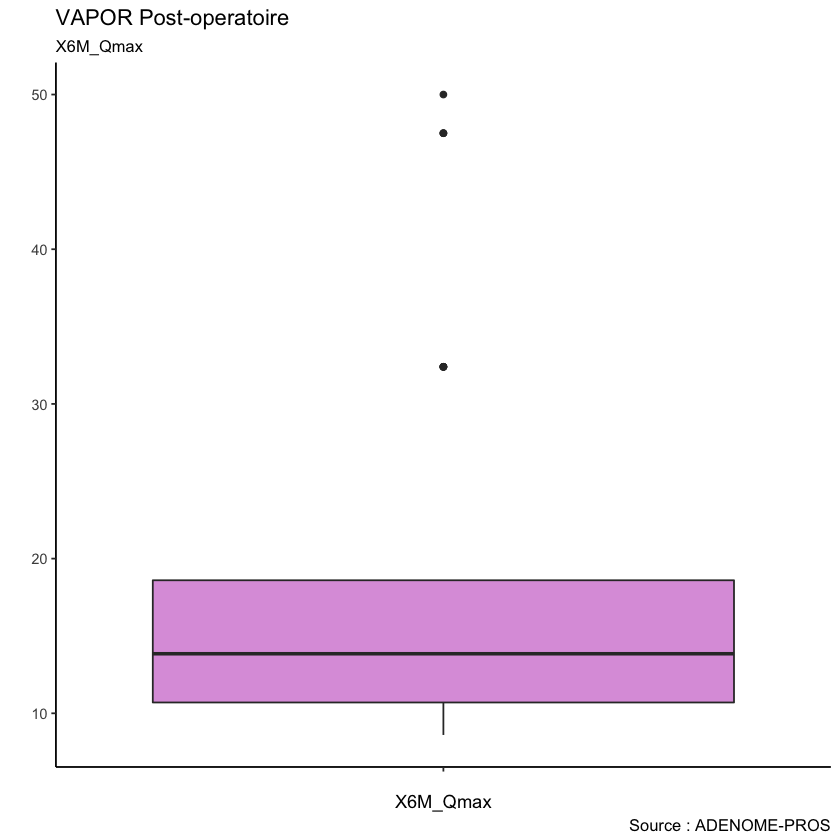

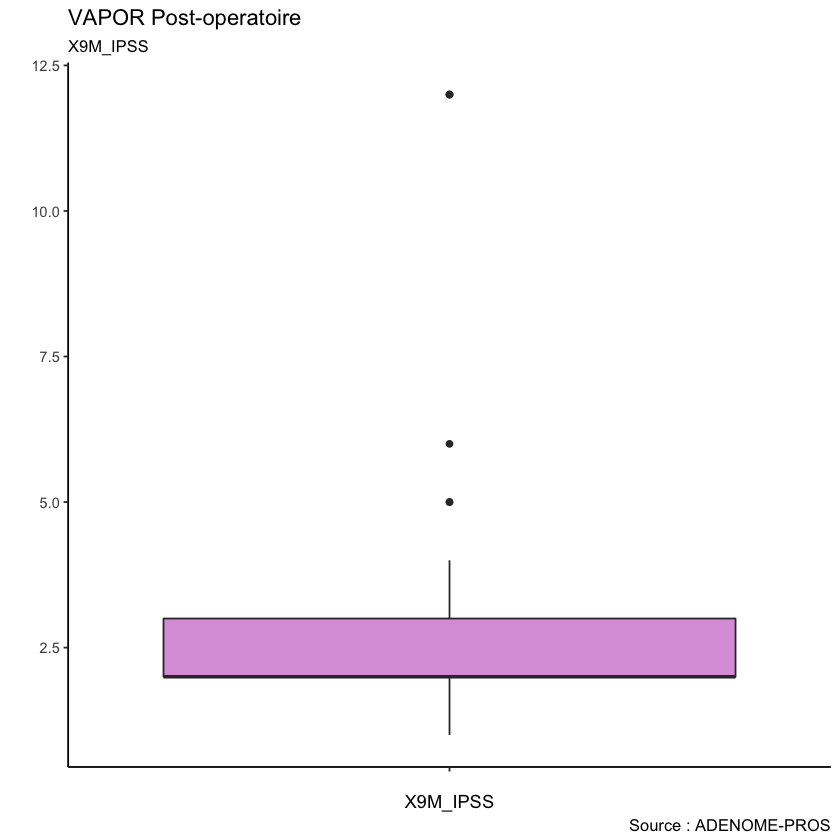

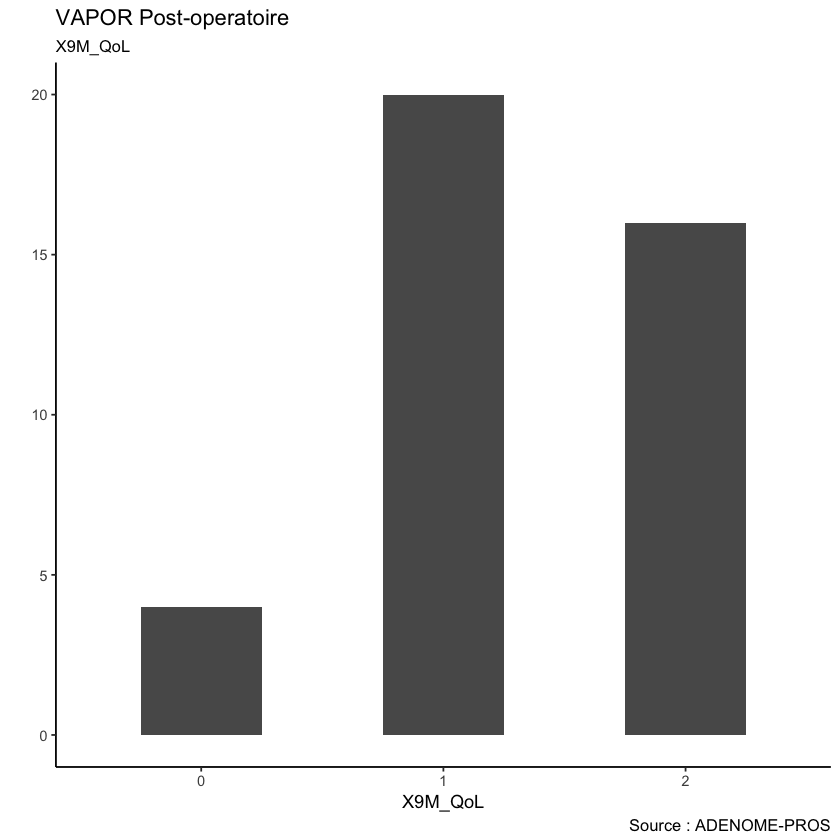

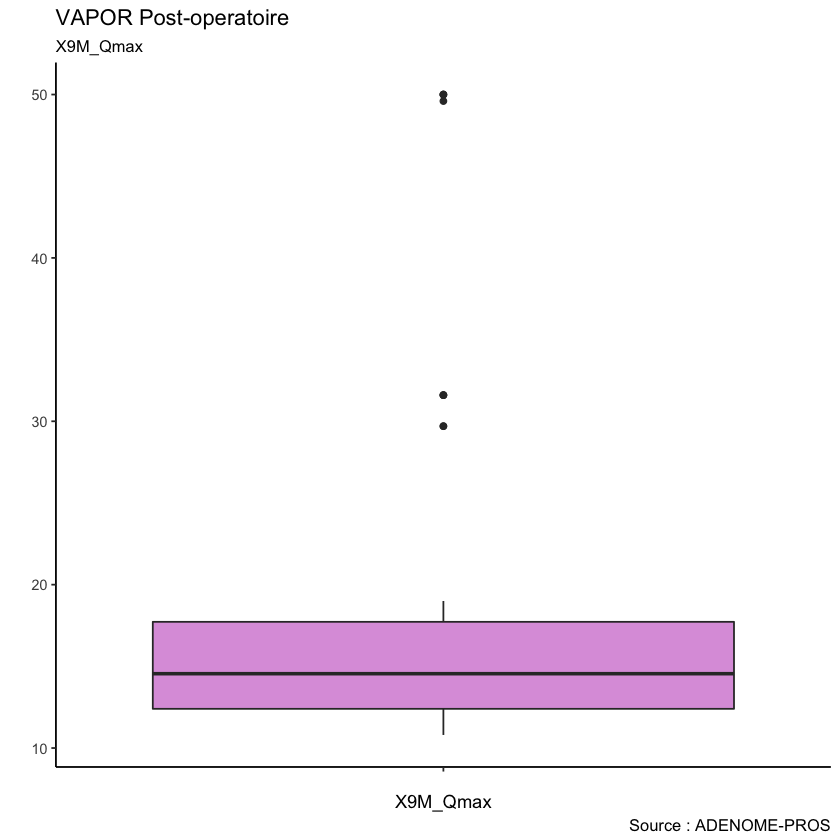

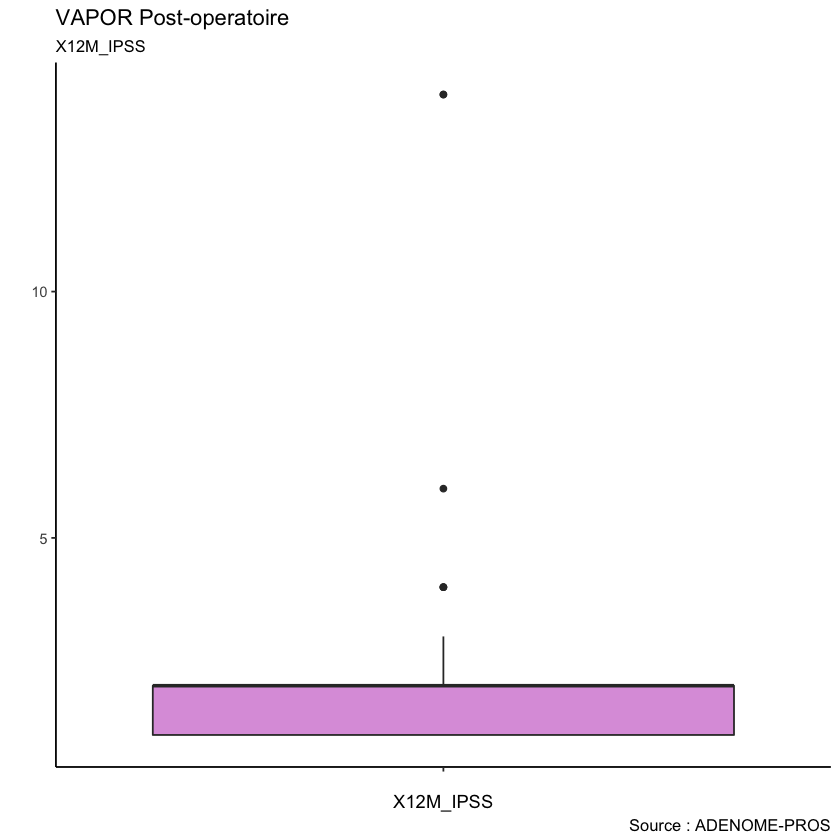

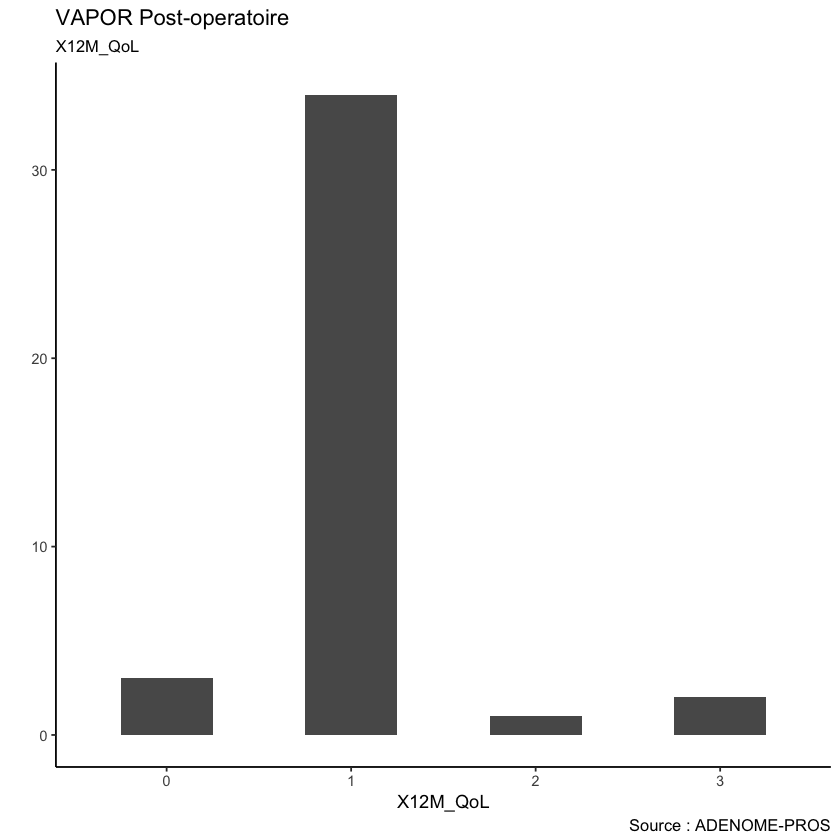

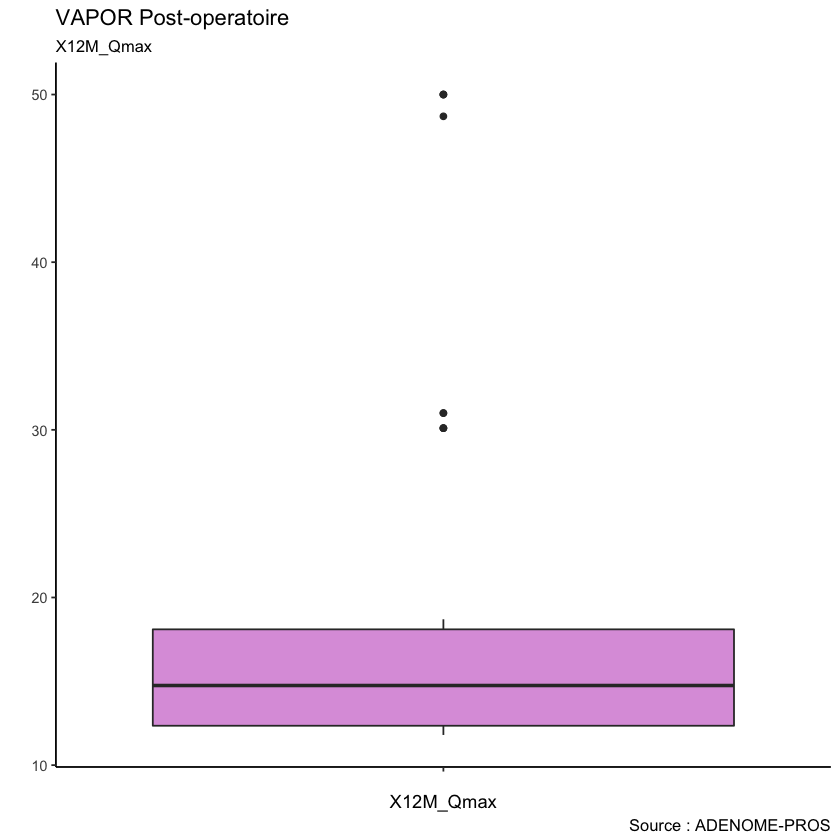

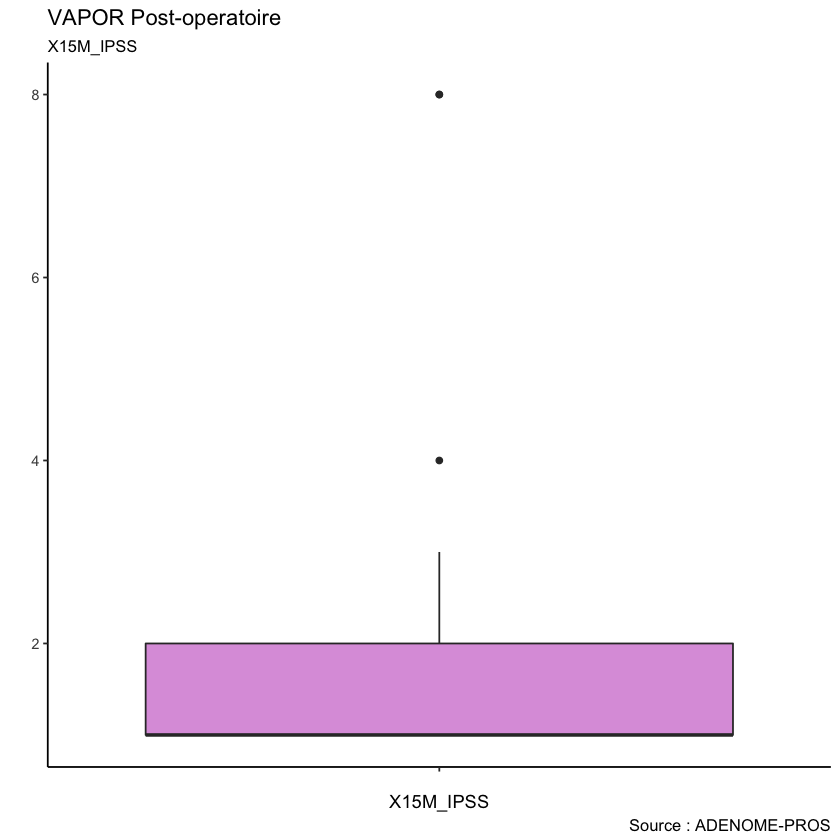

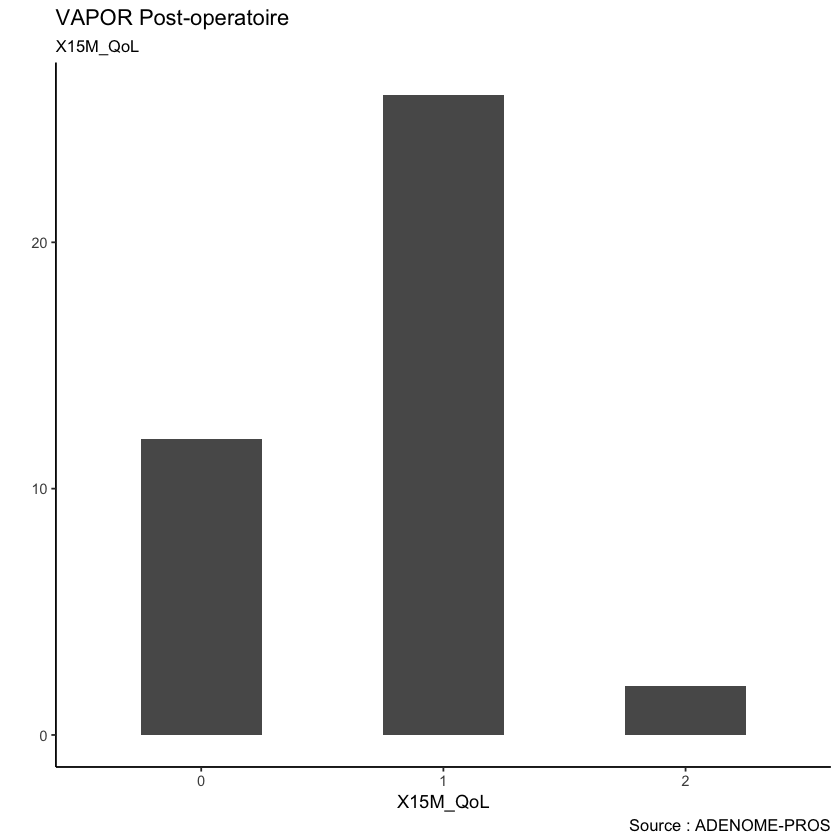

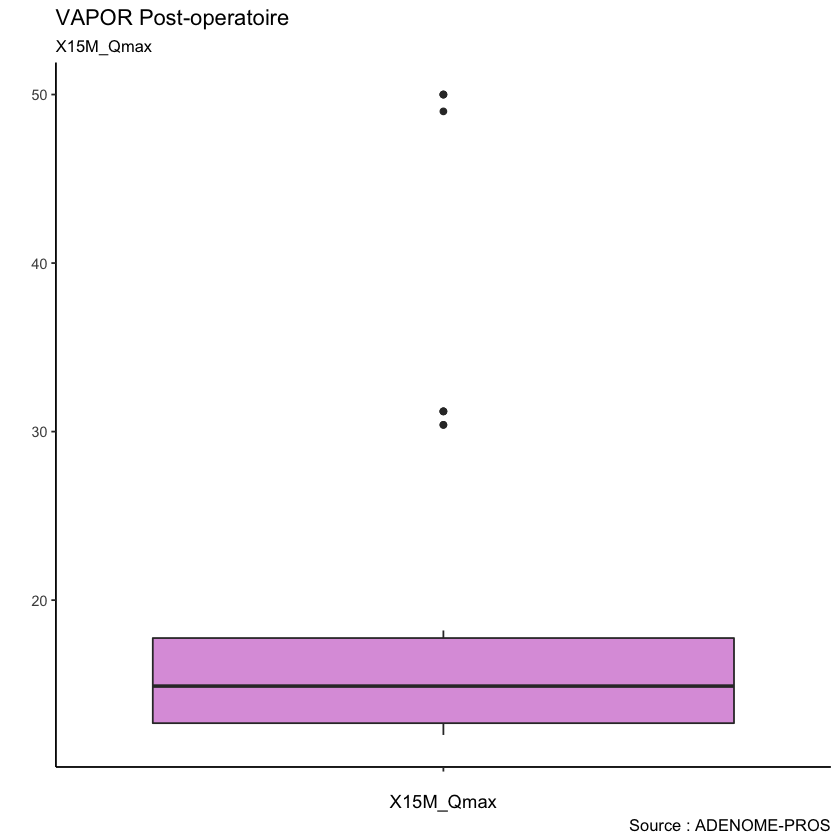

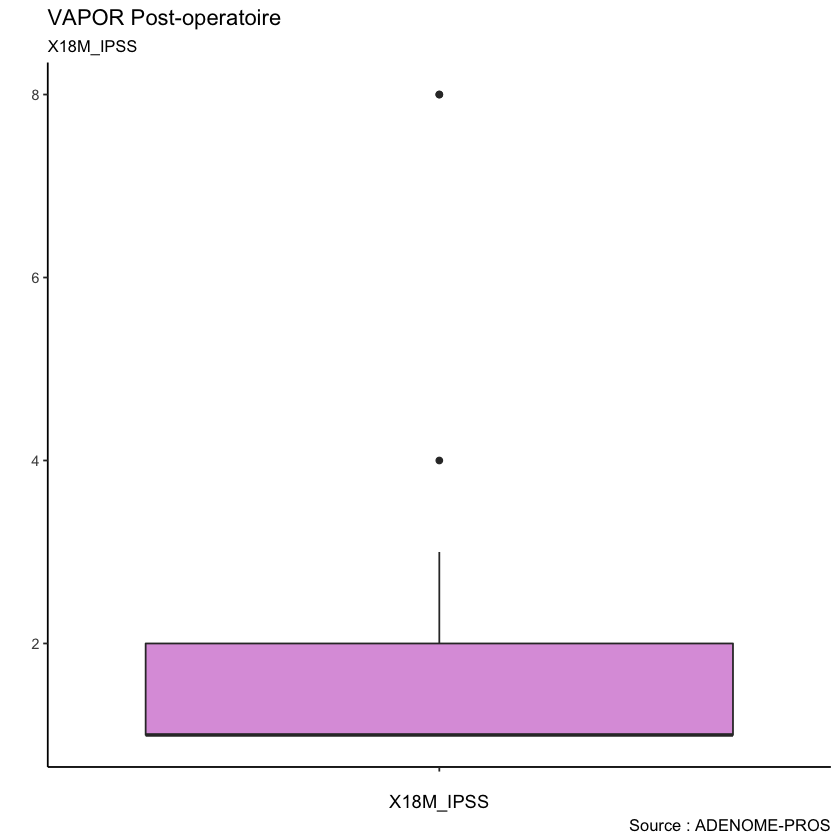

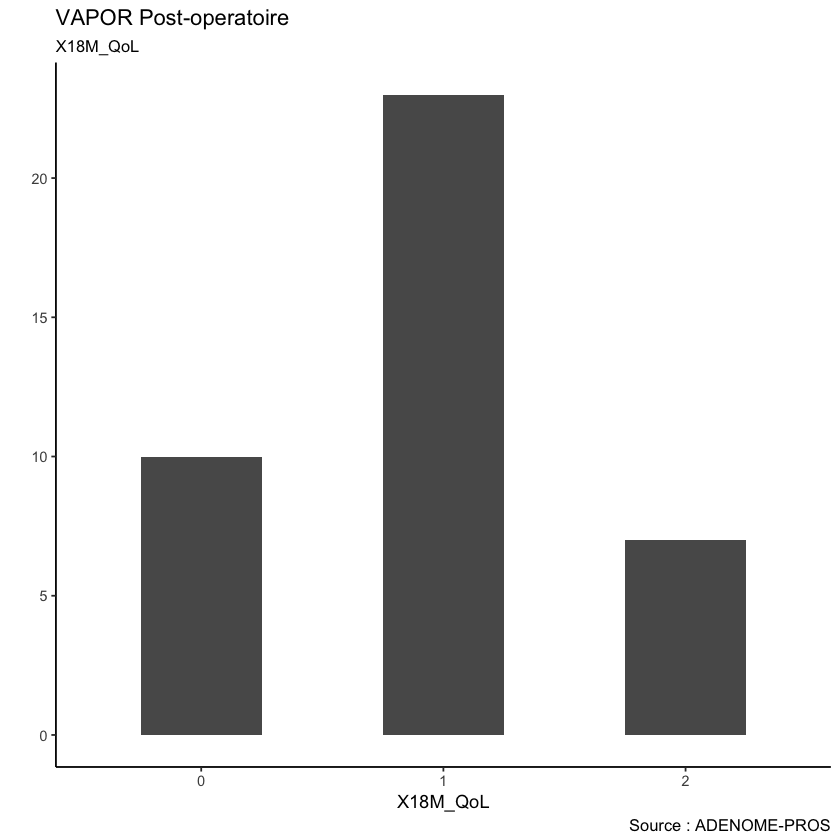

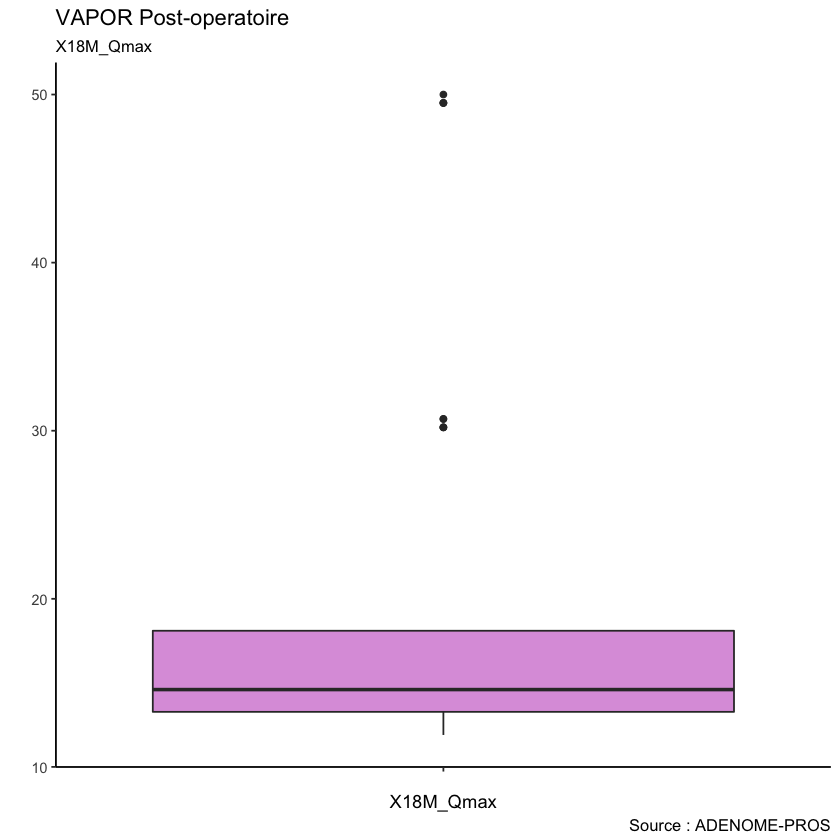

In [15]:
# Boxplots des variables numériques et barplots des variables catégoriques

for (i in 1:ncol(vapor_post)) {
  #x11(display="")
  if (is.numeric(vapor_post[,i]) || is.integer(vapor_post[,i])) {
    adenome_boxplot(vapor_post,i,"VAPOR Post-operatoire")
  }
  else
    adenome_barplot(vapor_post,i,"VAPOR Post-operatoire")
}

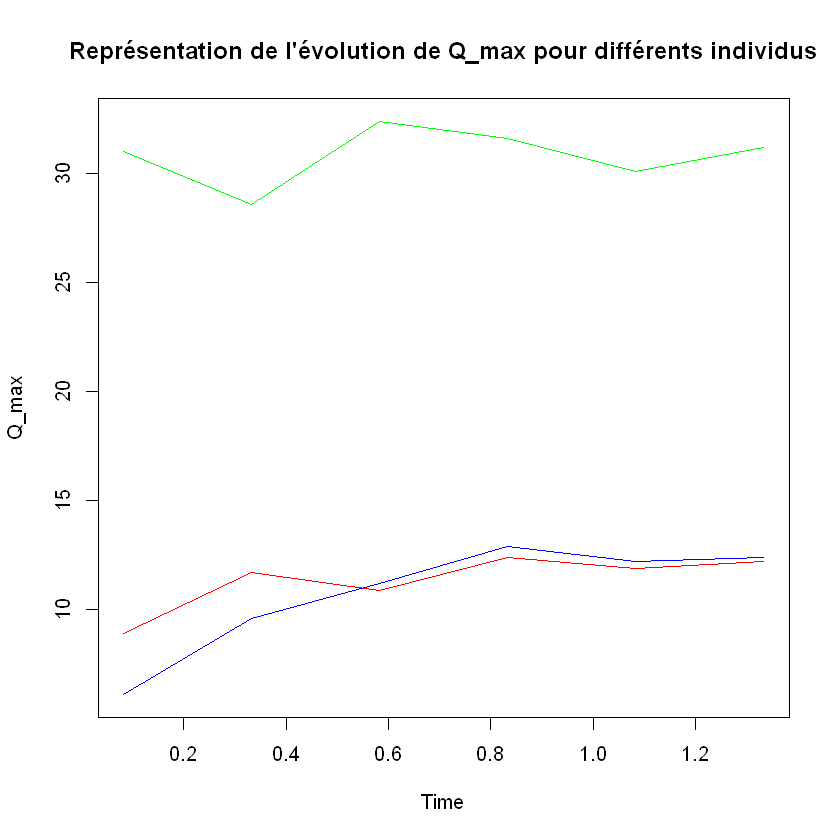

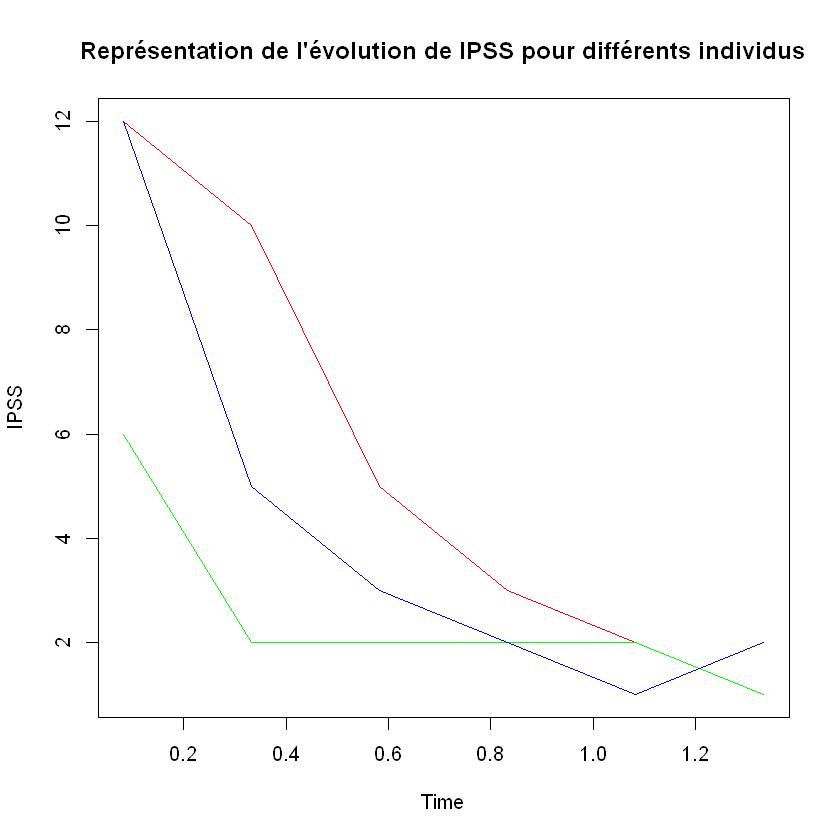

In [410]:
require(graphics)
individu= sample(1:nrow(vapor_num_post), 3)
i1=individu[1]
i2=individu[2]
i3=individu[3]
vapor_num_post_qmax=t(subset(vapor_num_post,select=c(X1M_Qmax,X3M_Qmax,X6M_Qmax,X9M_Qmax,X12M_Qmax,X15M_Qmax)))
vapor_num_post_ipss=t(subset(vapor_num_post,select=c(X1M_IPSS,X3M_IPSS,X6M_IPSS,X9M_IPSS,X12M_IPSS,X15M_IPSS)))
vapor_num_post_series_qmax=ts(vapor_num_post_qmax, start=1/12,deltat=3/12)
vapor_num_post_series_ipss=ts(vapor_num_post_ipss, start=1/12,deltat=3/12)
Q_max_Individu1=vapor_num_post_series_qmax[,i1]
Q_max_Individu2=vapor_num_post_series_qmax[,i2]
Q_max_Individu3=vapor_num_post_series_qmax[,i3]
Q_max=cbind(Q_max_Individu1,Q_max_Individu2,Q_max_Individu3)
ts.plot(Q_max,gpars= list(col=rainbow(3)),ylab= "Q_max",main="Représentation de l'évolution de Q_max pour différents individus")
Ipss_Individu1=vapor_num_post_series_ipss[,i1]
Ipss_Individu2=vapor_num_post_series_ipss[,i2]
Ipss_Individu3=vapor_num_post_series_ipss[,i3]
Ipss=cbind(Ipss_Individu1,Ipss_Individu2,Ipss_Individu3)
ts.plot(Ipss,gpars= list(col=rainbow(3)),ylab= "IPSS",main="Représentation de l'évolution de IPSS pour différents individus")


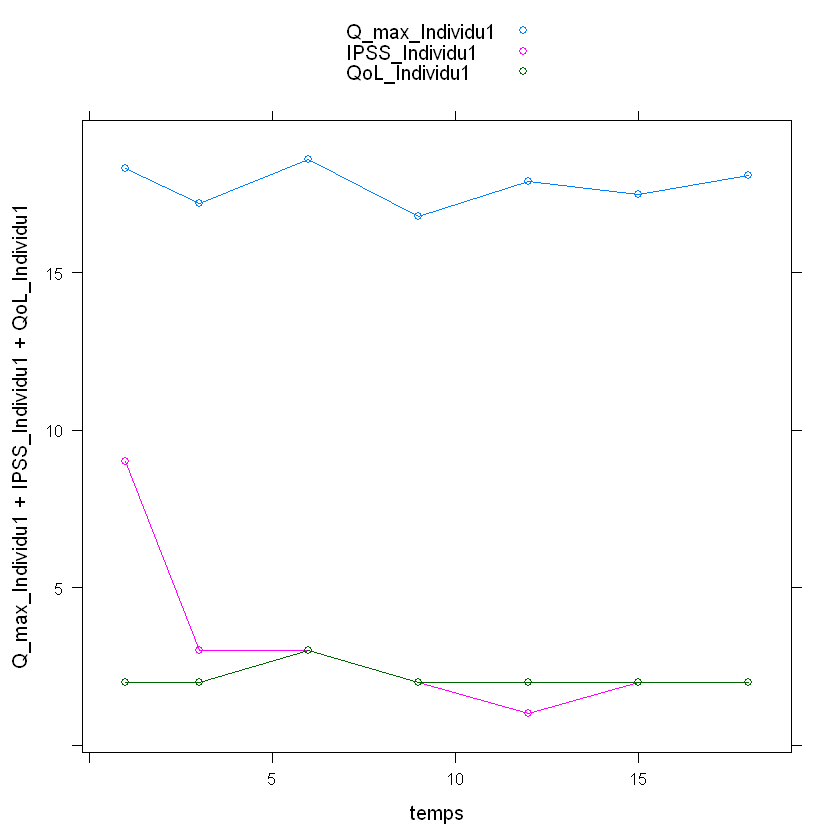

In [92]:
Q_max_Individu1=c(vapor_num_post$X1M_Qmax[i1],vapor_num_post$X3M_Qmax[i1],vapor_num_post$X6M_Qmax[i1],vapor_num_post$X9M_Qmax[i1],vapor_num_post$X12M_Qmax[i1],vapor_num_post$X15M_Qmax[i1],vapor_num_post$X18M_Qmax[i1])
IPSS_Individu1=c(vapor_num_post$X1M_IPSS[i1],vapor_num_post$X3M_IPSS[i1],vapor_num_post$X6M_IPSS[i1],vapor_num_post$X9M_IPSS[i1],vapor_num_post$X12M_IPSS[i1],vapor_num_post$X15M_IPSS[i1],vapor_num_post$X18M_IPSS[i1])
QoL_Individu1=c(vapor_cat_post$X1M_QoL[i1],vapor_cat_post$X3M_QoL[i1],vapor_cat_post$X6M_QoL[i1],vapor_cat_post$X9M_QoL[i1],vapor_cat_post$X12M_QoL[i1],vapor_cat_post$X15M_QoL[i1],vapor_cat_post$X18M_QoL[i1])
xyplot(Q_max_Individu1+IPSS_Individu1+QoL_Individu1 ~ temps, type = "b", auto.key = TRUE)

### 1.2.2 Corrélations entre les variables post-opératoire

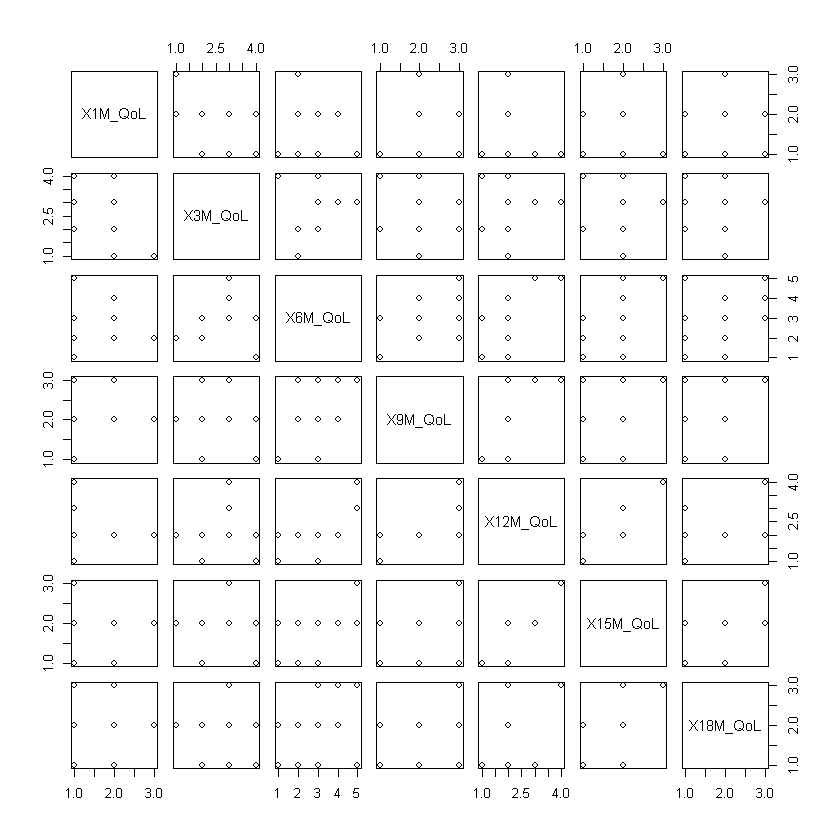

In [102]:
plot(vapor_cat_post)

# 2 Clustering des données VAPOR 
## 2.1 Extraction des profils types des patients à partir des données pré-opératoires
### 2.1.1 PAM

In [459]:
require(cluster)
library(fpc)
#On crée notre matrice de dissimilarité utilisant daisy car matrice hétérogène
vapor_pre_sans_res=subset(vapor_pre[which(vapor_pre$Residu_post_mictionnel != ""),])
disMatrix=daisy(vapor_pre_sans_res,metric = c("gower"))
#On fait une boucle pour repèrer les 5 meilleurs valeurs de k qui maximise la valeur silhouette
respam<- numeric(20)
for (k in 2:20)
respam[[k]] <- pam(disMatrix,k) $ silinfo $ avg.width
sortrespam=respam[which(respam>0.7)]
sortrespam=sort(sortrespam,decreasing=TRUE)
for (i in 1:length(sortrespam)){
        k.best[i] <-which(respam[]==sortrespam[i])
}
#On regarde le min de k pour une valeur silhouette supérieur à 0.7
k.min<-min(k.best)
    cat("Les 3 meilleurs nombre de clusters sont", k.best[1:3], ".Ayant une valeur silhouette de ",respam[k.best[1:3]],". Le nombre de cluster pour une valeur silhouette maximale est=" ,k.best[1]," . \n")
cat("Le nombre minimal de clusters pour une valeur silhouette supérieure à 0.7 est", k.min, " et ayant un valeur silhouette de ",respam[k.min],"\n")

Warning message in daisy(vapor_pre_sans_res, metric = c("gower")):
"setting 'logical' variables 2, 4, 15, 19, 20 to type 'asymm'"

Les 3 meilleurs nombre de clusters sont 9 8 7 .Ayant une valeur silhouette de  0.8130588 0.795227 0.7546298 . Le nombre de cluster pour une valeur silhouette maximale est= 9  . 
Le nombre minimal de clusters pour une valeur silhouette supérieure à 0.7 est 6  et ayant un valeur silhouette de  0.7399562 



Ainsi d'après cette comparaison on peut très bien voir que le nombre optimal de clusters à choisir est de 6. En effet cette valeur parait assez correcte vu   qu 'elle propose une valeur silhouette de 0.74 qui n'est pas trés loin de la valeur maximale qui est de 0.81 et qui propose des clusters d'une moyenne de 4 individus.

In [426]:
k.optimal=k.min

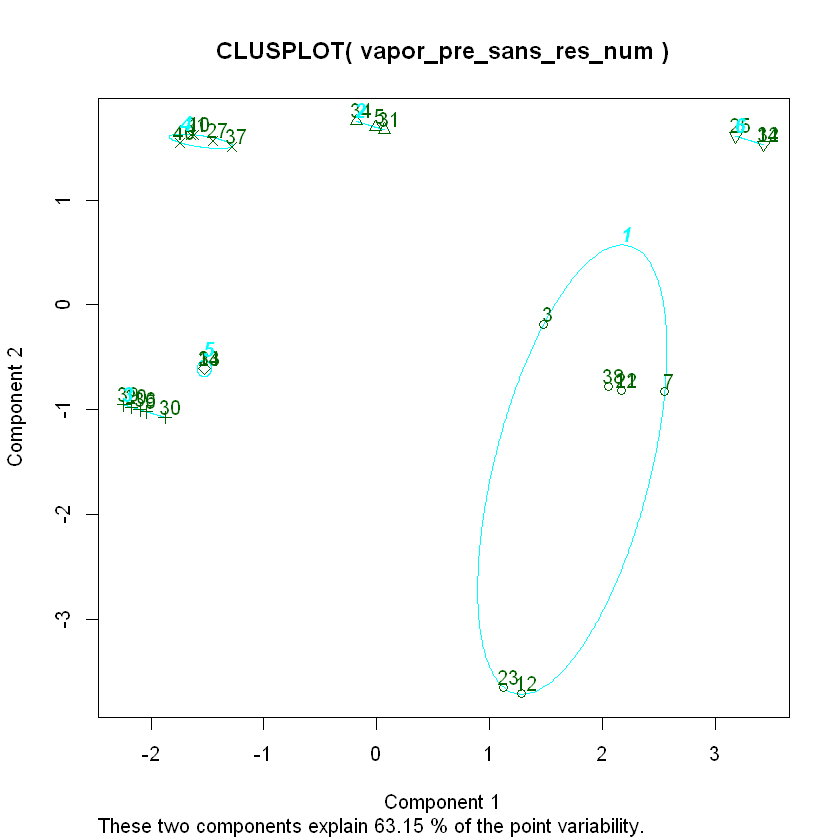

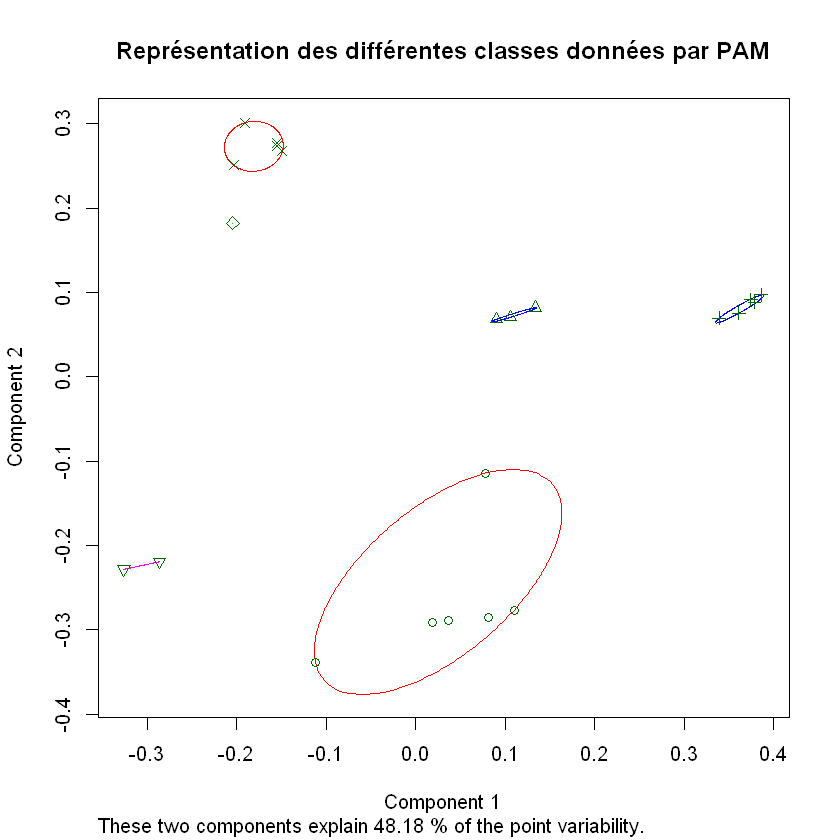

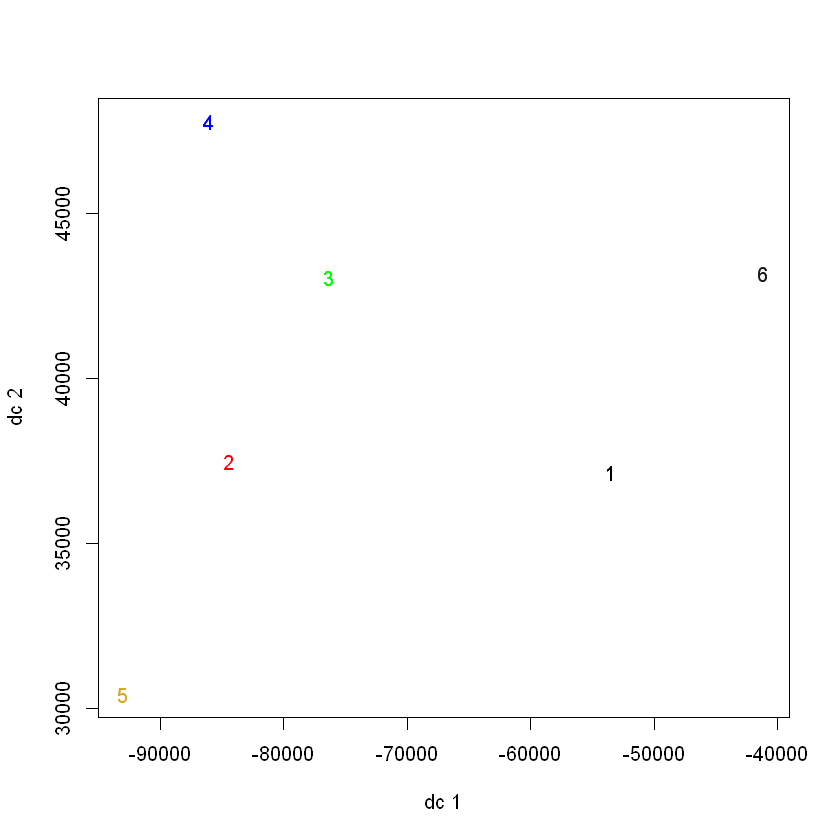

In [473]:
library(fpc)
respam_optimal=pam(disMatrix,6)
vapor_pre_sans_res_num=subset(vapor_num_pre[which(vapor_num_pre$Residu_post_mictionnel != ""),])
clusplot(vapor_pre_sans_res_num, respam_optimal$clustering, labels=2, lines=0)
clusplot(respam_optimal,main="Représentation des différentes classes données par PAM", color=TRUE, lines=0)
plotcluster(vapor_pre_sans_res_num,t(respam_optimal$clustering))

### 2.1.2 CAH

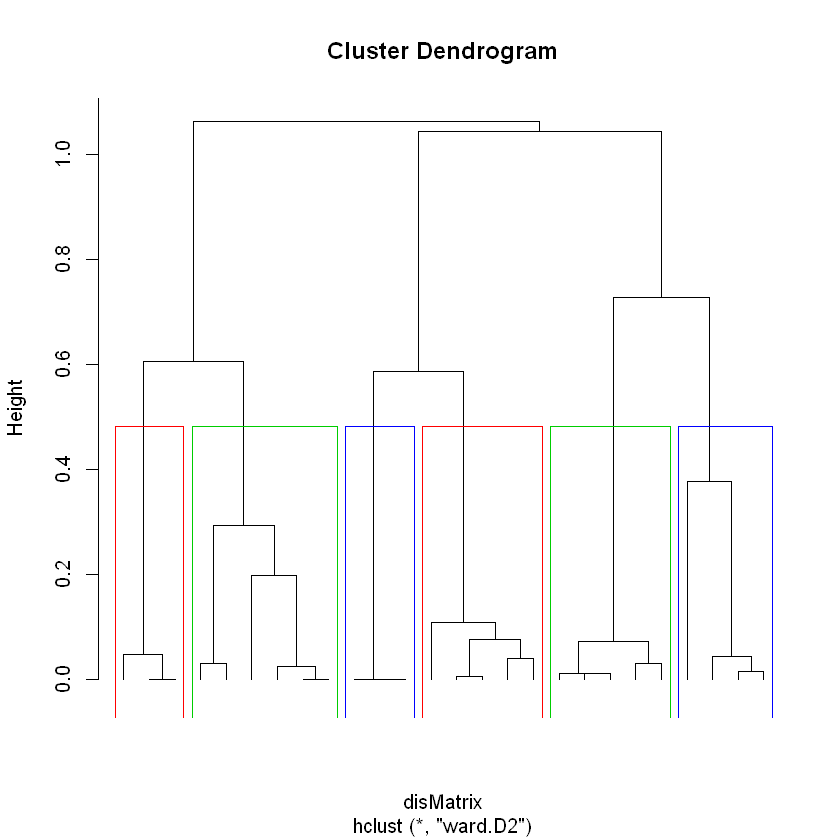

In [427]:
resuhc <- hclust(disMatrix, method = "ward.D2")
# Visualization de resuhc
plot(resuhc, labels = FALSE, hang = -1)
# Ajout des rectangles autour des clusters
rect.hclust(resuhc, k = k.optimal, border = 2:4) 

### 2.1.3 Caractérisation des patients médoids

In [439]:
#Indication des médoids
medoid_pre=c()
medoids_pre=pam(disMatrix,k=k.optimal)$medoids
for (i in 1:length(medoids_pre)){
   medoid_pre=rbind(medoid_pre,vapor[medoids_pre[i],])
    }
medoid_pre
    

,Age,Comorbidite,Duree_Traitement_Medical,Porteur_Sonde,IPSS,QoL,Qmax,PSA,Volume_Prostatique,Residu_post_mictionnel,...,X9M_Qmax,X12M_IPSS,X12M_QoL,X12M_Qmax,X15M_IPSS,X15M_QoL,X15M_Qmax,X18M_IPSS,X18M_QoL,X18M_Qmax
22,68,FALSE,11,FALSE,22,5,5.1,3.25,86,80,...,16.2,3,1,17.9,2,1,17.6,2,1,17.8
5,65,FALSE,12,FALSE,29,6,5.3,3.40,150,50,...,50.0,2,1,50.0,3,1,50.0,3,1,49.5
20,73,FALSE,72,FALSE,20,6,9.0,4.57,166,180,...,31.6,2,1,30.1,1,1,31.2,1,1,30.2
10,63,FALSE,120,FALSE,26,5,8.5,4.15,126,200,...,12.3,1,1,14.2,2,1,14.0,2,2,14.2
33,74,TRUE,72,FALSE,24,5,6.6,7.41,119,0,...,14.9,4,0,15.2,1,0,15.6,1,0,15.8
32,58,TRUE,21,FALSE,26,5,2.4,1.15,78,0,...,11.3,14,3,12.2,8,2,12.0,8,2,12.0


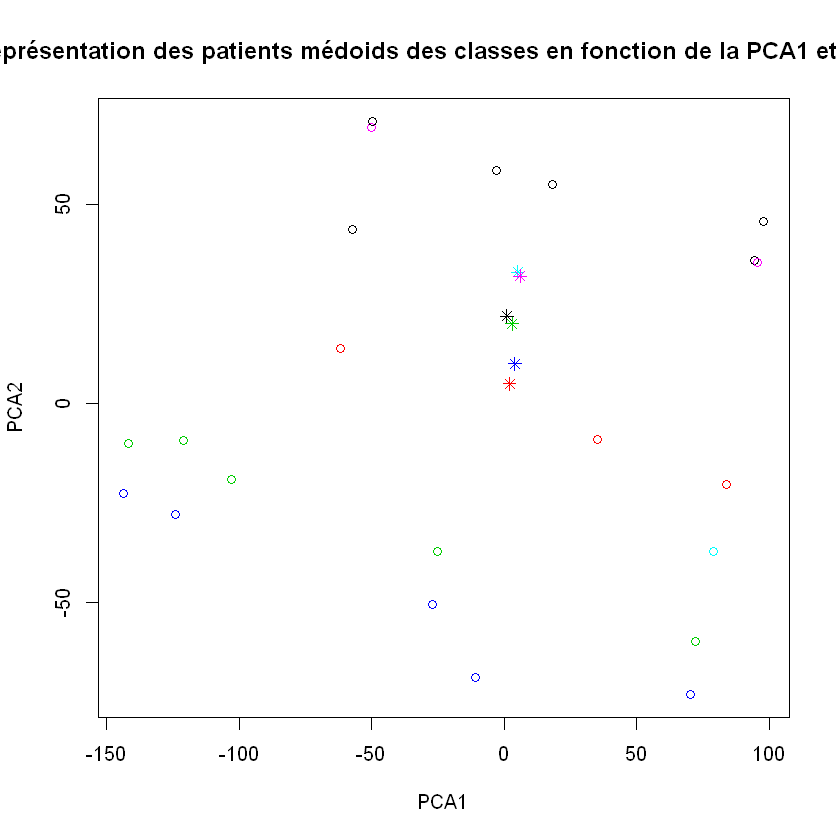

In [429]:
#On choisit un k optimal pour poursuivre notre étude et on essaye de faire pam dessus et de dessiner nos classes utilisant une acp
respam_optimal=pam(disMatrix,k.optimal)
plot(pca$x[,1],pca$x[,2],col=respam_optimal$clustering,xlab="PCA1",ylab="PCA2",main="Représentation des patients médoids des classes en fonction de la PCA1 et PCA2 ")
points(respam_optimal$medoids,col=1:11,pch=8)

## 2.1.4 Visualtisation des distributions du Q_max à 12 mois pour les différentes classes

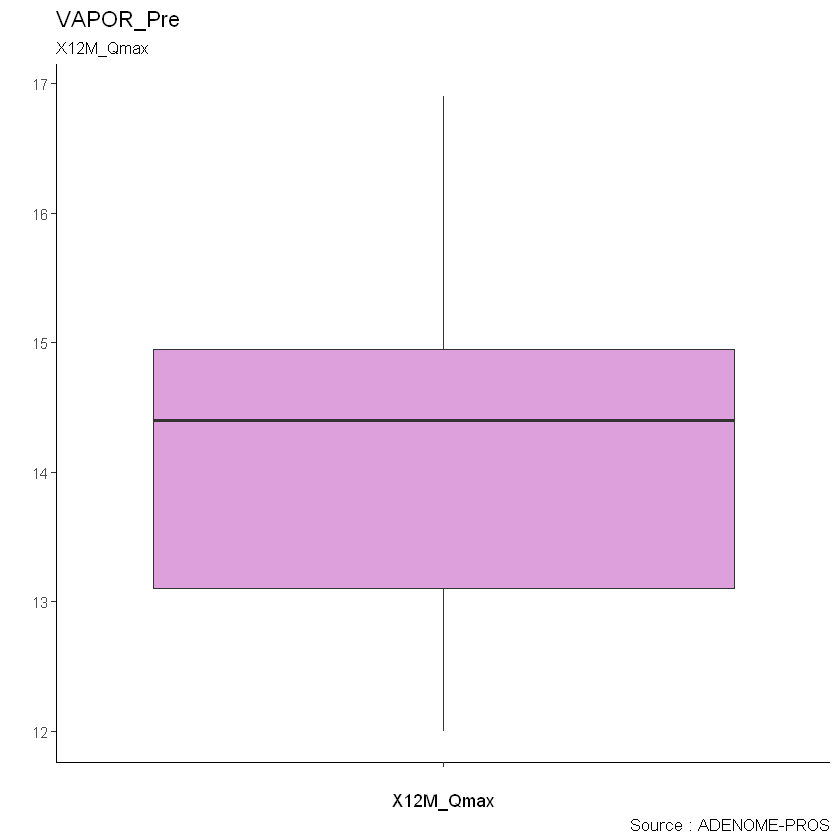

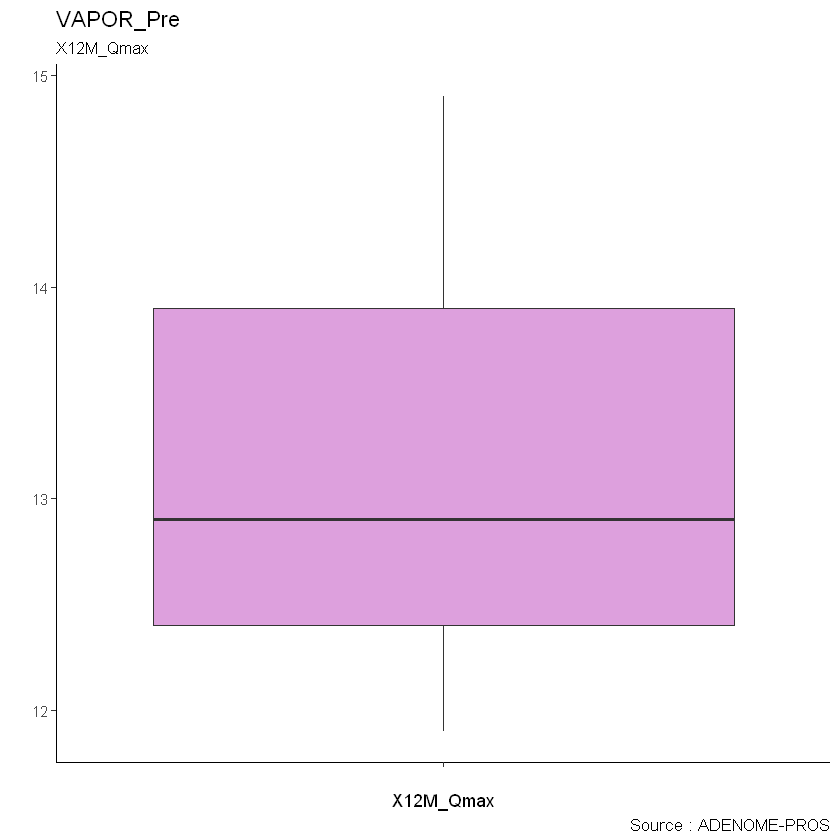

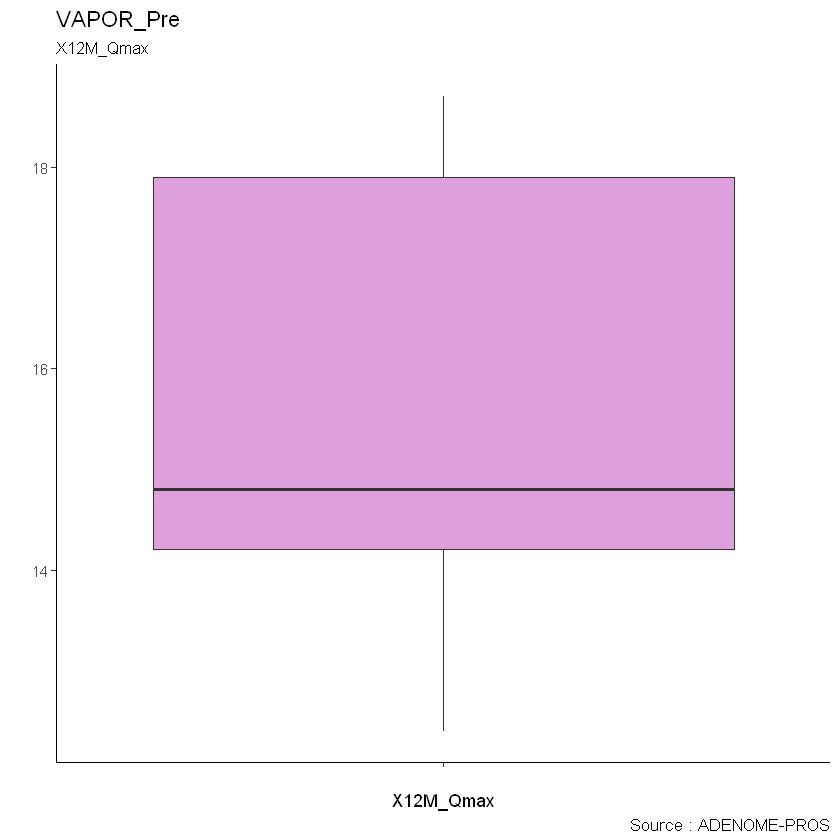

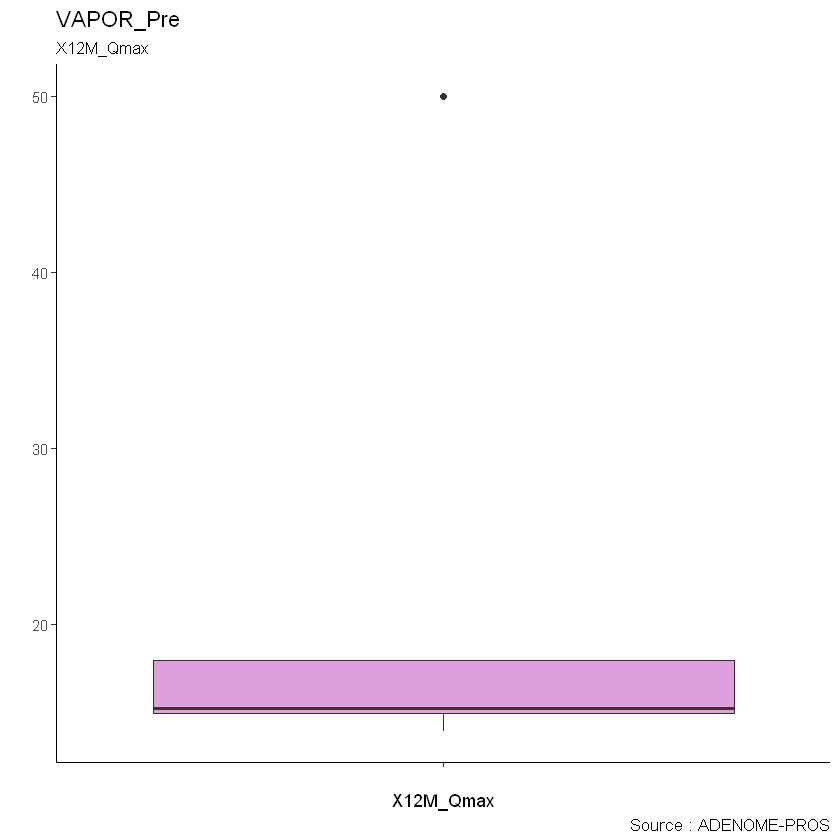

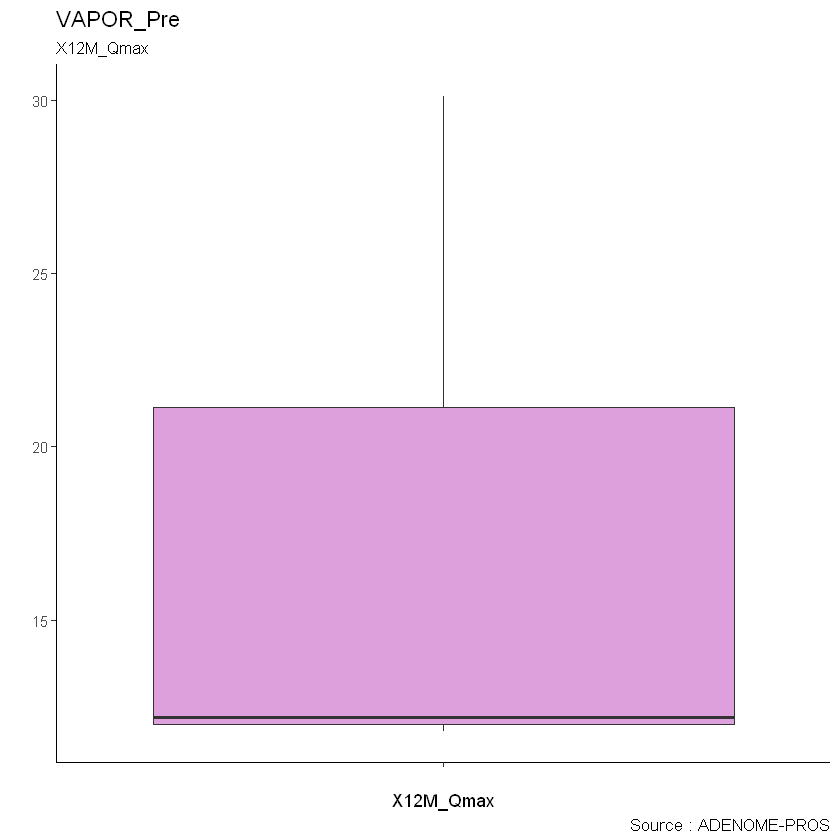

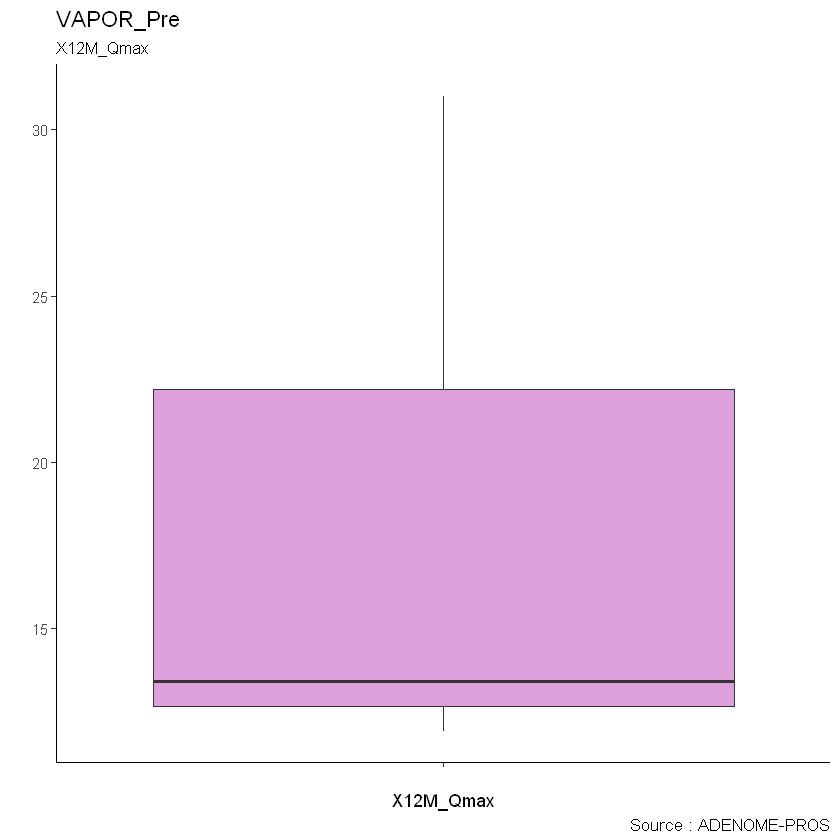

In [430]:
clusters=respam_optimal$clustering
for(i in 1:k.optimal){
    clust=which(clusters==i)
    adenome_boxplot(vapor_post[clust,],15,"VAPOR_Pre")
    }


## 2.2 Extraction des profils types des patients à partir des données post-opératoires
### 2.2.1 PAM

In [411]:
#On crée une matrice de dissimilarité utilisant la distance euclidienne
disMatrix=dist(vapor_post , method="euclidean")
#On fait une boucle pour repèrer les 5 meilleurs valeurs de k qui maximise la valeur silhouette
respam<- numeric(20)
for (k in 2:20)
respam[[k]] <- pam(disMatrix,k) $ silinfo $ avg.width
sortrespam=respam[which(respam>0.7)]
sortrespam=sort(sortrespam,decreasing=TRUE)
for (i in 1:5){
    if(i <= length(sortrespam))
k.best[i] <-which(respam[]==sortrespam[i])
        }
#On regarde le min de k pour une valeur silhouette supérieur à 0.7
k.min<-which(respam==min(sortrespam))
cat("Les 5 meilleurs nombre de clusters sont", k.best, ".Ayant une valeur silhouette de ",respam[k.best[1]]," pour un nombre de cluster=" ,k.best[1]," . \n")
cat("Le nombre minimal de clusters pour une valeur silhouette supérieure à 0.7 est", k.min, " et ayant un valeur silhouette de ",respam[k.min],"\n")



Les 5 meilleurs nombre de clusters sont 3 2 15 17 13 .Ayant une valeur silhouette de  0.7494372  pour un nombre de cluster= 3  . 
Le nombre minimal de clusters pour une valeur silhouette supérieure à 0.7 est 2  et ayant un valeur silhouette de  0.7403069 


In [257]:
k.optimal=k.best[1]

### 2.2.2 CAH

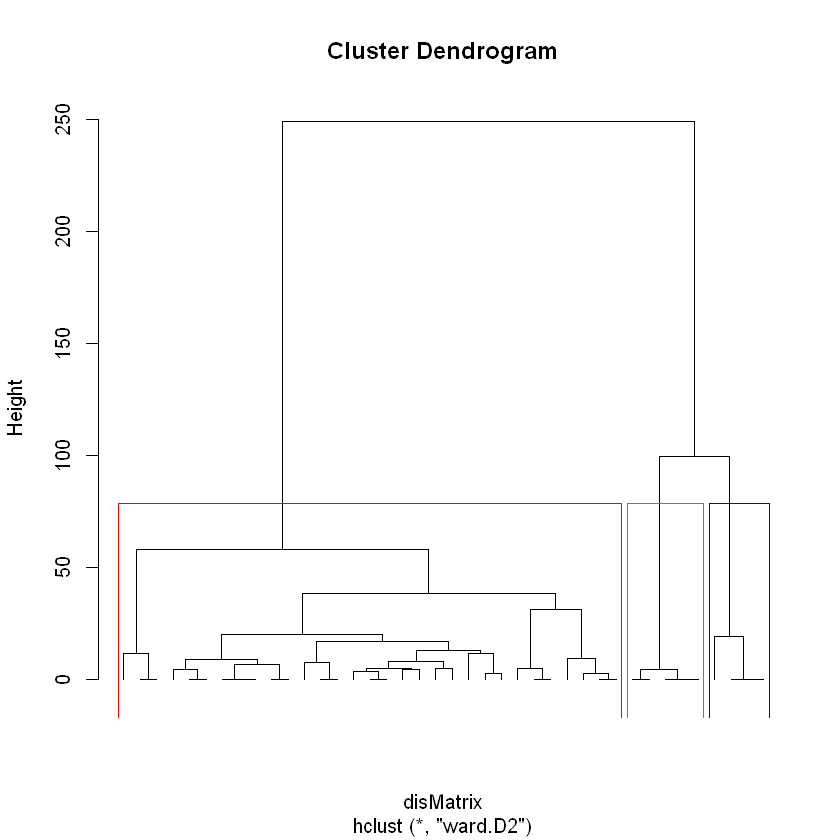

In [255]:
resuhc <- hclust(disMatrix, method = "ward.D2")
# Visualization de resuhc
plot(resuhc, labels = FALSE, hang = -1)
# Ajout des rectangles autour des clusters
rect.hclust(resuhc, k = k.optimal, border = 2:4) 

La CAH perlet de bien valider le nombre de clusters trouvé en faisant l'étude PAM ainsi on retrouve 3 classes différentes.

### 2.2.3 Caractérisation des patients médoids

In [273]:
#Indication des médoids
medoid_post=c()
medoids_post=pam(disMatrix,k=k.optimal)$medoids
for (i in 1:length(medoids_post)){
    medoid_post=rbind(medoid_post,vapor[medoids_post[i],])
}
medoid_post

    

,Age,Comorbidite,Duree_Traitement_Medical,Porteur_Sonde,IPSS,QoL,Qmax,PSA,Volume_Prostatique,Indication,Anesthesie,Evenement,Technique,Transfusion,Tmps_OP,Volume_Reseque,Delai_ablation,Caillotage,Reprise_Bloc
1,81,FALSE,24,TRUE,35,6,0.0,3.75,95,1,1,0,3,FALSE,65,59,3,FALSE,FALSE
34,65,FALSE,12,FALSE,29,6,5.3,3.40,150,5,1,0,3,FALSE,75,100,3,FALSE,FALSE
39,73,FALSE,72,FALSE,20,6,9.0,4.57,166,2,2,0,3,FALSE,75,65,4,FALSE,FALSE
